### Objetivos del notebook
---
En el presente notebook vamos a aprender a utilizar el algoritmo de XGBoost para trabajar con Series Temporales.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

A pesar de tener sus carencias para problemas de Series Temporales (por ejemplo: no es capaz de extrapolar una tendencia), el algoritmo es muy versátil y todo Data Scientist debe conocerlo. 

El dataset con el que vamos a trabajar en este notebook contiene un total de **426 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. Por tanto vamos a trabajar con **Series Temporales Multivariante**.

Cada una de estas **Series Temporales** representan las ventas <u>**MENSUALES**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

Al final del notebook, el alumno debe estar familiarizado con:

1. **La importancia de establecer un benchmark (CORE IDEA)** cuando empezamos a trabajar en un problema de Machine Learning. <br>
2. Saber utilizar **pandas de forma eficiente para manipular el dataset (resample de pandas, groupby etc).** <br>
3. **Combinar la información de diferentes Series Temporales para generar variables (ventas totales de un artículo, ventas totales de todos los artículos en una tienda) con las que alimentar nuestro modelo XGBoost (CORE IDEA).**<br>
4. **Saber identificar las variables autoexplicativas (COREA IDEA)** y sus principales causas.<br>
5. Comprender **la importancia de iterar rápido (realizar muchos experimentos) (CORE IDEA)** para testear diferentes hipótesis y variables que se construyen.

---

El presente notebook contiene muchas funcionalidades avanzadas que puede requerir varias lecturas para su comprensión.
Pensamos que las secciones marcadas con **CORE IDEA** son las que mayor beneficio le reportarán al alumno. Por este motivo, le animamos a que dedique especial atención a estas ideas.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

<a id='index'></a>
### Índice

[Imports del notebook](#imports_notebook)<br>
[Data Loading](#data_load)<br>
[La idea del Benchmark (**CORE IDEA**)](#benchmark)<br>
[Data Imputation](#impute)<br>
[EDA](#eda)<br>
[--> 1. EDA: Global Sales](#eda_global_sales)<br>
[--> 2. EDA: Top 3 Cities](#eda_top_3_cities)<br>
[--> 3. EDA: Top 3 Categories](#eda_top_3_categories)<br>
[Build Time Series Features (**CORE IDEA**)](#build_ts_features)<br>
[Join TS Features](#join_ts_features)<br>
[Train Test Split](#train_test_split)<br>
[Model Train](#model_train)<br>
[Model Evaluation (**COREA IDEA**)](#model_evaluation)<br>
[Prediction](#prediction)<br>

### Conclusión
[Conclusión](#conclusion)<br>

### Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
### Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [4782]:
import pickle
import os

import math

from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf

import warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [4783]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")
FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

#### Functions

In [4784]:
def preprocess_and_evaluate_series(df, column_name):
    # Crear un diccionario para almacenar el primer valor logarítmico de cada serie identificada por unique_id
    first_values = {}

    # Crear una copia del DataFrame para no modificar el original
    df_copy = df.copy(deep=True)

    # Crear columnas de transformación logarítmica y diferenciación usando transform
    df_copy[f"{column_name}_log"] = df_copy.groupby("unique_id")[column_name].transform(lambda x: np.log1p(x))
    df_copy[f"{column_name}_log_diff"] = df_copy.groupby("unique_id")[f"{column_name}_log"].transform(lambda x: x.diff())

    # Guardar el primer valor logarítmico de cada grupo para revertir la transformación
    for unique_id, group in df_copy.groupby("unique_id"):
        first_values[unique_id] = group[f"{column_name}_log"].iloc[0]

    # Eliminar filas con valores nulos creados por la diferenciación
    df_copy.dropna(subset=[f"{column_name}_log_diff"], inplace=True)

    # Procesar el DataFrame eliminando las columnas originales y renombrando
    df_processed = process_log_diff(df_copy, column_name)

    return df_processed, first_values

def process_log_diff(df, column_name):
    '''
    Elimina la columna de la escala original y la columna logarítmica, renombra la columna log_diff a la escala original y elimina valores nulos.
    '''
    dfr = df.copy(deep=True)
    # Eliminar columnas de la escala original y logarítmica
    dfr.drop(columns=[column_name, f"{column_name}_log"], inplace=True)
    # Renombrar la columna diferenciada log a la escala original
    dfr.rename(columns={f"{column_name}_log_diff": column_name}, inplace=True)
    # Eliminar filas con valores nulos
    dfr.dropna(axis=0, inplace=True)
    
    return dfr


In [4785]:
def log_diff_to_original(df, first_value, column_name="monthly_sales"):
    '''
    Convierte de log_diff a la escala original para una columna específica.
    
    Parámetros:
    - df: DataFrame que contiene la columna de diferencias logarítmicas.
    - first_value: Primer valor original para la serie (anterior a la transformación).
    - column_name: Nombre de la columna de diferencias logarítmicas (log_diff).
    
    Retorna:
    - df: DataFrame con una nueva columna convertida a la escala original.
    '''
    df = df.copy(deep=True)
    
    # Crear una copia de la columna log_diff para el cálculo acumulado
    df[f"{column_name}_log_"] = df[column_name]
    
    # Sumar el primer valor histórico a la primera fila de la serie logarítmica acumulada
    df.iloc[0, df.columns.get_loc(f"{column_name}_log_")] = first_value + df.iloc[0, df.columns.get_loc(column_name)]
    
    # Cálculo acumulativo y conversión a escala logarítmica original
    df[f"{column_name}_log"] = df[f"{column_name}_log_"].cumsum()
    df[f"{column_name}_original"] = df[f"{column_name}_log"].apply(np.exp) - 1
    
    return df

def convert_all_to_original_scale(df, first_values_dict, column_name="monthly_sales"):
    '''
    Convierte cada grupo de series temporales a la escala original usando `log_diff_to_original` para cada unique_id.
    
    Parámetros:
    - df: DataFrame con la columna de diferencias logarítmicas (log_diff), "unique_id" y "date".
    - first_values_dict: Diccionario donde las claves son unique_id y los valores son los primeros valores históricos para cada serie.
    - column_name: Nombre de la columna de diferencias logarítmicas (log_diff).
    
    Retorna:
    - df: DataFrame original con la columna en la escala original reemplazando el log-diff.
    '''
    # Iterar sobre cada grupo de unique_id en el DataFrame
    for unique_id, group in df.groupby("unique_id"):
        # Verificar si unique_id está en el diccionario de primeros valores
        if unique_id in first_values_dict:
            first_value = first_values_dict[unique_id]
            
            # Convertir el grupo a la escala original usando log_diff_to_original
            original_values = log_diff_to_original(group, first_value, column_name)[f"{column_name}_original"]
            
            # Asignar la columna convertida a la escala original en `df` y eliminar la columna intermedia
            df.loc[group.index, column_name] = original_values

    # Eliminar cualquier columna intermedia creada durante el proceso
    df.drop(columns=[f"{column_name}_log", f"{column_name}_log_", f"{column_name}_original"], inplace=True, errors='ignore')
    
    return df


In [4786]:
# Funcion para visualizar timeseries
def plot_unique_id_series(df, items_per_plot=10, plots_per_row=3):
    """
    Grafica series temporales de múltiples unique_id en una retícula de subplots.

    Parámetros:
    df (DataFrame): DataFrame que contiene las columnas "unique_id", "monthly_sales", y "date".
    items_per_plot (int): Número de unique_id por gráfico.
    plots_per_row (int): Número de gráficos por fila.
    """
    # Lista de valores únicos de unique_id
    unique_ids = df["unique_id"].unique()

    # Configuración para la retícula
    num_plots = math.ceil(len(unique_ids) / items_per_plot)  # Número total de gráficos
    num_rows = math.ceil(num_plots / plots_per_row)  # Número de filas necesarias

    # Crear una figura y retícula de subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(14, 4 * num_rows))
    axes = axes.flatten()  # Aplanar para iterar fácilmente
    fig.suptitle("Monthly Sales for Unique IDs", fontsize=16)

    # Iterar sobre unique_ids en bloques de items_per_plot
    for i, ax in enumerate(axes):
        start_idx = i * items_per_plot
        end_idx = start_idx + items_per_plot
        unique_ids_subset = unique_ids[start_idx:end_idx]

        # Verificar si el índice está dentro del rango de unique_ids
        if start_idx >= len(unique_ids):
            fig.delaxes(ax)  # Eliminar cualquier eje sobrante en la retícula
            continue

        # Graficar cada unique_id en el mismo gráfico
        for unique_id in unique_ids_subset:
            # Filtrar los datos para el unique_id actual
            y = df[df["unique_id"] == unique_id]["monthly_sales"][:-2]
            x = df[df["unique_id"] == unique_id]["date"][:-2]

            # Graficar la serie de tiempo de unique_id en el mismo gráfico
            ax.plot(x, y, label=f"{unique_id}")

        # Formatear los ticks para mostrar solo mes y año
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%m-%Y"))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
        plt.setp(ax.get_yticklabels(), fontsize=8)

        # Configurar etiquetas y leyenda
        ax.set_xlabel("Date", fontsize=8)
        ax.set_ylabel("Monthly Sales", fontsize=8)
        ax.legend(fontsize=8)
        ax.set_title(f"Unique IDs {start_idx + 1} to {min(end_idx, len(unique_ids))}", fontsize=8)

    # Ajustar el diseño y mostrar la figura
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [4787]:
def is_white_noise(series, confidence_level=1.96):
    """
    Determina si una serie es ruido blanco en función de su autocorrelación.
    
    Parámetros:
    - series: Pandas Series de la serie temporal a evaluar.
    - confidence_level: Nivel de confianza para considerar los valores de autocorrelación.
    
    Retorna:
    - white_noise: True si la serie cumple con el criterio de ruido blanco, False en caso contrario.
    """
    acf_values = acf(series, fft=True, nlags=20)  # Hasta 20 retardos
    confidence_interval = confidence_level / np.sqrt(len(series))  # Intervalo de confianza
    return all(abs(acf_val) < confidence_interval for acf_val in acf_values[1:])

def analyze_series(df, column_name, threshold_dominance=0.6, unique_values_threshold=3, diff_threshold=0.1, variance_threshold=1e-4, window_size=8):
    """
    Analiza cada serie temporal (definida por unique_id) y determina si es estacionaria,
    ruido blanco, constante o tiene un plato. Diferencia automáticamente las series hasta dos veces si no son estacionarias.
    Devuelve un DataFrame con los resultados y listas adicionales.

    Parámetros:
    - df: DataFrame que contiene los datos de series temporales, incluyendo "unique_id" y la columna de datos.
    - column_name: Nombre de la columna que contiene los datos de la serie temporal.
    - threshold_dominance: Umbral para considerar una serie como constante si un solo valor domina.
    - unique_values_threshold: Umbral de valores únicos para considerar una serie constante.
    - diff_threshold: Umbral de diferencias medias consecutivas para considerar una serie constante.
    - variance_threshold: Umbral de varianza para identificar un plato en ventanas deslizantes.
    - window_size: Tamaño de la ventana deslizante para detectar un plato.

    Retorna:
    - result_df: DataFrame con columnas "unique_id", "stationary", "white_noise", "constant",
                 "plateau", "ADF Statistic", "p-value", "correlacion", y resultados de diferenciación.
    - white_noise_list: Lista de unique_id que cumplen con el criterio de ruido blanco.
    - plateau_list: Lista de unique_id que cumplen con el criterio de plato.
    - constant_list: Lista de unique_id que cumplen con el criterio de constante.
    """

    # Listas para almacenar resultados y clasificaciones
    results = []
    white_noise_list = []
    plateau_list = []
    constant_list = []

    # Iterar sobre cada unique_id y analizar su serie temporal
    for unique_id, group in df.groupby("unique_id"):
        series = group[column_name].iloc[:-1].dropna()  # Excluir el último valor de cada grupo

        # Verificar si la serie es constante usando el umbral de dominancia y otros criterios
        value_counts = series.value_counts(normalize=True, ascending=False)
        if (series.nunique() <= unique_values_threshold or
            value_counts.iloc[0] > threshold_dominance or
            series.diff().abs().mean() < diff_threshold):
            
            # Si es constante, no se realiza el análisis de estacionariedad
            constant_list.append(unique_id)
            results.append({
                "unique_id": unique_id,
                "stationary": "No",
                "white_noise": "No",
                "constant": "Yes",
                "plateau": "No",
                "ADF Statistic": None,
                "p-value": None,
                "correlacion": None,
                "ADF Statistic diff1": None,
                "p-value diff1": None,
                "correlacion diff1": None,
                "white_noise diff1": None,
                "ADF Statistic diff2": None,
                "p-value diff2": None,
                "correlacion diff2": None,
                "white_noise diff2": None
            })
            continue

        # Verificar si la serie tiene un plato usando una ventana deslizante y la varianza
        has_plateau = False
        for i in range(len(series) - window_size + 1):
            window = series[i:i + window_size]
            if np.var(window) < variance_threshold:
                has_plateau = True
                break

        if has_plateau:
            plateau_list.append(unique_id)
            results.append({
                "unique_id": unique_id,
                "stationary": "No",
                "white_noise": "No",
                "constant": "No",
                "plateau": "Yes",
                "ADF Statistic": None,
                "p-value": None,
                "correlacion": None,
                "ADF Statistic diff1": None,
                "p-value diff1": None,
                "correlacion diff1": None,
                "white_noise diff1": None,
                "ADF Statistic diff2": None,
                "p-value diff2": None,
                "correlacion diff2": None,
                "white_noise diff2": None
            })
            continue

        # Si no es constante ni tiene plato, aplicar la prueba ADF para determinar si la serie es estacionaria
        def run_adf(series):
            try:
                adf_result = adfuller(series)
                return adf_result[0], adf_result[1]  # ADF Statistic y p-value
            except (ValueError, np.linalg.LinAlgError):
                return None, None

        adf_stat, p_value = run_adf(series)
        stationary = "Yes" if p_value and p_value < 0.05 else "No"
        avg_correlation = np.mean(np.abs(acf(series, fft=True, nlags=20)[1:])) if p_value else None

        # Evaluar ruido blanco en la serie original
        white_noise = "Yes" if stationary == "Yes" and is_white_noise(series) else "No"
        if white_noise == "Yes":
            white_noise_list.append(unique_id)

        # Si no es estacionaria, diferenciar hasta 2 veces
        diff1_stat, diff1_pvalue, diff1_corr, white_noise_diff1 = None, None, None, None
        diff2_stat, diff2_pvalue, diff2_corr, white_noise_diff2 = None, None, None, None

        if stationary == "No":
            # Primera diferenciación
            diff1_series = series.diff().dropna()
            diff1_stat, diff1_pvalue = run_adf(diff1_series)
            diff1_corr = np.mean(np.abs(acf(diff1_series, fft=True, nlags=20)[1:])) if diff1_pvalue else None
            white_noise_diff1 = "Yes" if diff1_pvalue and diff1_pvalue < 0.05 and is_white_noise(diff1_series) else "No"
            if white_noise_diff1 == "Yes":
                white_noise_list.append(unique_id)

            # Segunda diferenciación si la primera no es estacionaria
            if diff1_pvalue and diff1_pvalue >= 0.05:
                diff2_series = diff1_series.diff().dropna()
                diff2_stat, diff2_pvalue = run_adf(diff2_series)
                diff2_corr = np.mean(np.abs(acf(diff2_series, fft=True, nlags=20)[1:])) if diff2_pvalue else None
                white_noise_diff2 = "Yes" if diff2_pvalue and diff2_pvalue < 0.05 and is_white_noise(diff2_series) else "No"
                if white_noise_diff2 == "Yes":
                    white_noise_list.append(unique_id)

        # Agregar los resultados al DataFrame
        results.append({
            "unique_id": unique_id,
            "stationary": stationary,
            "white_noise": white_noise,
            "constant": "No",
            "plateau": "No",
            "ADF Statistic": adf_stat,
            "p-value": p_value,
            "correlacion": avg_correlation,
            "ADF Statistic diff1": diff1_stat,
            "p-value diff1": diff1_pvalue,
            "correlacion diff1": diff1_corr,
            "white_noise diff1": white_noise_diff1,
            "ADF Statistic diff2": diff2_stat,
            "p-value diff2": diff2_pvalue,
            "correlacion diff2": diff2_corr,
            "white_noise diff2": white_noise_diff2
        })

    # Convertir la lista de resultados a DataFrame
    result_df = pd.DataFrame(results)
    return result_df, white_noise_list, plateau_list, constant_list


In [4788]:
# Definir la función que crea el heatmap y elimina las columnas con alta correlación
def plot_correlation_and_find_columns_to_drop(df, numerical_columns, target_col='monthly_sales',drop_threshold=0.95,filter_threshold=0.001,fig_size_df=(15, 15)):
    # Calcular la matriz de correlación solo con las columnas numéricas
    corr_matrix = df[numerical_columns].corr()

    # Filtrar las correlaciones mayores a 0.95 (en valor absoluto), excluyendo las correlaciones de 1.0
    high_corr_pairs = corr_matrix[(corr_matrix.abs() > drop_threshold) & (corr_matrix != 1.0)]

    # Crear una lista para almacenar las columnas a eliminar
    columns_to_drop_corr = []

    # Recorrer las columnas y filas de la matriz de correlación filtrada 
    for col in high_corr_pairs.columns:
        for idx in high_corr_pairs.index:
            if pd.notna(high_corr_pairs.loc[idx, col]) and col != target_col and idx != target_col:  # Evitar 'churn' con 'churn'
                # Obtener las correlaciones de 'churn' con las dos variables
                churn_corr_col = corr_matrix[target_col].get(col, None)
                churn_corr_with = corr_matrix[target_col].get(idx, None)

                # Comparar los valores absolutos de las correlaciones con 'churn' e identificar cuál eliminar
                if abs(churn_corr_col) > abs(churn_corr_with):
                    column_to_drop_corr = idx  # Si 'col' tiene mayor correlación con churn, se propone eliminar 'idx'
                else:
                    column_to_drop_corr = col  # Si 'idx' tiene mayor correlación con churn, se propone eliminar 'col'

                # Añadir la columna a eliminar a la lista
                columns_to_drop_corr.append(column_to_drop_corr)

    # Eliminar duplicados en la lista de columnas a eliminar
    columns_to_drop_corr = list(set(columns_to_drop_corr))

    # Crear una matriz de anotaciones donde solo las correlaciones > filter_threshold sean visibles
    annot_matrix = corr_matrix.applymap(lambda x: f'{x:.2f}' if abs(x) > filter_threshold else '')

    # Crear el heatmap de la matriz de correlación
    plt.figure(figsize=fig_size_df)
    heatmap = sns.heatmap(corr_matrix,
                          annot=annot_matrix,
                          cmap='coolwarm',
                          fmt="",
                          linewidths=0.5,
                          annot_kws={"size": 12},
                          cbar_kws={'label': 'Correlación'})

    # Aumentar el tamaño de las etiquetas de la barra de color
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=24)
    cbar.set_label('Correlación', fontsize=24)

    # Añadir título y cambiar tamaños de las fuentes
    plt.title(f"Heatmap de Correlaciones con Anotaciones > {filter_threshold}", fontsize=28)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    # Mostrar el gráfico
    plt.show()

    # Devolver la lista de columnas a eliminar
    return columns_to_drop_corr

<a id='data_load'></a>
### Data Loading
[Volver al índice](#index)

Vamos a cargar nuestro dataset para comenzar con el EDA.

In [4789]:
df = pd.read_csv(TRAIN_CSV_PATH, index_col = 0)

df1 = pd.read_csv(TRAIN_CSV_PATH, index_col = 0)
df1.sample(3)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
4743,2013-05-31,28_16169,7,28,65,16169,299.000000,7.0
14039,2015-06-30,6_7856,21,6,28,7856,1032.333333,7.0
7869,2015-06-30,31_15438,7,31,63,15438,1049.000000,6.0


Vamos a ver que tipo de datos tenemos en nuestro dataset.

In [4790]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1018.4+ KB


In [4791]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")
df1["date"] = pd.to_datetime(df1["date"], format = "%Y-%m-%d")

<a id='benchmark'></a>
### La idea del Benchmark (CORE IDEA)
[Volver al índice](#index)

En el presente notebook buscamos establecer un benchmark rápido. 

El motivo fundamental es porque los datasets en la vida real son muy complejos y no tenemos el "lujo" de poder analizar todas y cada una de las variables <u>**ANTES DE ENTRENAR NUESTRO PRIMER MODELO.</u>**

Establecer un benchmark nos ayuda a entender cual es el punto de partida, es decir: <u>**cual es el score mínimo para este dataset.**</u>

Muchas veces este benchmark puede ser un modelo entrenado con unas pocas columnas númericas (imputando los nulos con la media). <u>**No se trata de tener el mejor modelo sino de entrenar nuestro primer modelo.**</u> 

Una vez sabemos cual es el punto de partida y tenemos un notebook **"funcional"** podemos empezar a experimentar con nuestro dataset. Por **"notebook funcional"** entendemos un script/notebook que podemos ejecutar en su totalidad (loading del dataset, preprocessing, train_test_split, train y predict). En cada experimento iremos añadiendo nuevas variables, diferentes imputaciones, modelos y vamos guardando el score que obtenemos. De este manera, podemos ver la contribución de cada variables y comprobar si estamos mejorando o no respecto al benchmark.

Dado que este notebook es un benchmark, tenemos que **"acotar"** muy bien las cosas que vamos a implementar (para no irnos por las ramas).

A **grosso modo** vamos a hacer las siguientes cosas:

1. Tratar los nulos.
1. Realizar un pequeño EDA sobre el dataset.
1. Crear algunas variables rápidas para el entrenamiento.
1. Entrenar el algoritmo.
1. Evaluar el modelo.
1. Hacer el submit a Kaggle.

Empecemos:

Tenemos un total de 426 Series Temporales en el dataset:

In [4792]:
df["unique_id"].nunique()

426

Veamos cuales son las fechas min y max de nuestro dataset:

In [4793]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

In [4794]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [4795]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

In [4796]:
df[df["monthly_sales"].isnull()].head(10)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
231,2015-10-31,12_11365,16,12,9,11365,NaN,NaN
232,2015-10-31,12_11369,16,12,9,11369,NaN,NaN
233,2015-10-31,12_11370,16,12,9,11370,NaN,NaN
234,2015-10-31,12_11373,16,12,9,11373,NaN,NaN
235,2015-10-31,12_12231,16,12,49,12231,NaN,NaN
236,2015-10-31,12_482,16,12,73,482,NaN,NaN
237,2015-10-31,12_839,16,12,73,839,NaN,NaN
238,2013-01-31,14_20949,3,14,71,20949,NaN,NaN
239,2013-01-31,14_4244,3,14,23,4244,NaN,NaN
244,2013-02-28,14_20949,3,14,71,20949,NaN,NaN


<a id='impute'></a>
### Data Imputation
[Volver al índice](#index)<br>

In [4797]:
sample_ts = "31_4249"

In [4798]:
df1[df1["unique_id"] == sample_ts].head(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.0000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.0000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.4160,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.9000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.9375,8.0


In [4799]:
df.fillna({"monthly_sales":0}, inplace = True)
df1.fillna({"monthly_sales":0}, inplace = True)

In [4800]:
df["monthly_average_price"] = df.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(
      lambda series: series.bfill().ffill()
 )

# probamos con interpolar y bfill
df1["monthly_average_price"] = df1.groupby("unique_id", group_keys=False)["monthly_average_price"].apply(
       lambda series: series.interpolate().bfill()
)



In [4801]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  14484 non-null  float64       
 7   monthly_sales          14484 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


In [4802]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [4803]:
df1.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [4804]:
df.sort_values(["unique_id", "date"], ascending = True, inplace = True)
df1.sort_values(["unique_id", "date"], ascending = True, inplace = True)

In [4805]:
# plot_unique_id_series(df, items_per_plot=10, plots_per_row=4)
# se ve que hay seríes constantes, seríes que tieenen pocos puntos

In [4806]:
#df2=df.copy(deep=True)

In [4807]:
# trabajar con la escala logaritmica
#df_2, first_values_dict = preprocess_and_evaluate_series(df2, column_name="monthly_sales")
#df_2.head()


In [4808]:
#df2_original=convert_all_to_original_scale(df_2, first_values_dict, column_name="monthly_sales")
#df2_original.head(3)

In [4809]:
df[df["unique_id"] == sample_ts].head(3)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416,6.0


In [4810]:
df.head(3)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0


In [4811]:
df1.head(3)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0


In [4812]:
#  Mirar que columnas son ruido blanco,constantes o tienen plateau
result_df, white_noise_list, plateau_list, constant_list = analyze_series(df, column_name="monthly_sales")

In [4813]:

# Mostrar el DataFrame resultante con las características de cada serie
result_df.head(3)

,unique_id,stationary,white_noise,constant,plateau,ADF Statistic,p-value,correlacion,ADF Statistic diff1,p-value diff1,correlacion diff1,white_noise diff1,ADF Statistic diff2,p-value diff2,correlacion diff2,white_noise diff2
0,12_11365,Yes,Yes,No,No,-4.044959,0.001193,0.121936,NaN,NaN,NaN,None,NaN,NaN,NaN,None
1,12_11369,No,No,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None
2,12_11370,No,No,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None


In [4814]:
print(f"Series ruido blanco: {len(white_noise_list)}, constante: {len(constant_list)}, tienen plateau: {len(plateau_list)}")

Series ruido blanco: 166, constante: 26, tienen plateau: 6


In [4815]:
# Series que son ruido blanco despues de la primera y segunda diferenciacion
# print(f"Series que se han comprobardo de ser ruido blanco despues de primera diferenciación: {len(result_df[result_df["white_noise diff1"]=="Yes"])}, segunda diferenciación: {len(result_df[result_df["white_noise diff2"]=="Yes"])}")

In [4816]:
# Ejemplos series que se detectan como ruido despues de 1 differenciacion
# for unique_id in ["24_5823","24_2308","25_16184","16_17717"]:
#      series_wn=df1[df1["unique_id"]==unique_id]["monthly_sales"][:-2]
#      series_wn_dif=df1[df1["unique_id"]==unique_id]["monthly_sales"].diff().dropna()
#      fig,(ax1,ax2,ax3,ax4)=plt.subplots(nrows=1,ncols=4,figsize=(16,3))
#      ax1.plot(series_wn)
#      ax1.set_title(f"Serie: {unique_id}")
#      plot_acf(series_wn,ax=ax2);
#      ax3.plot(series_wn_dif)
#      ax3.set_title(f"Serie diff: {unique_id}")
#      plot_acf(series_wn_dif,ax=ax4);

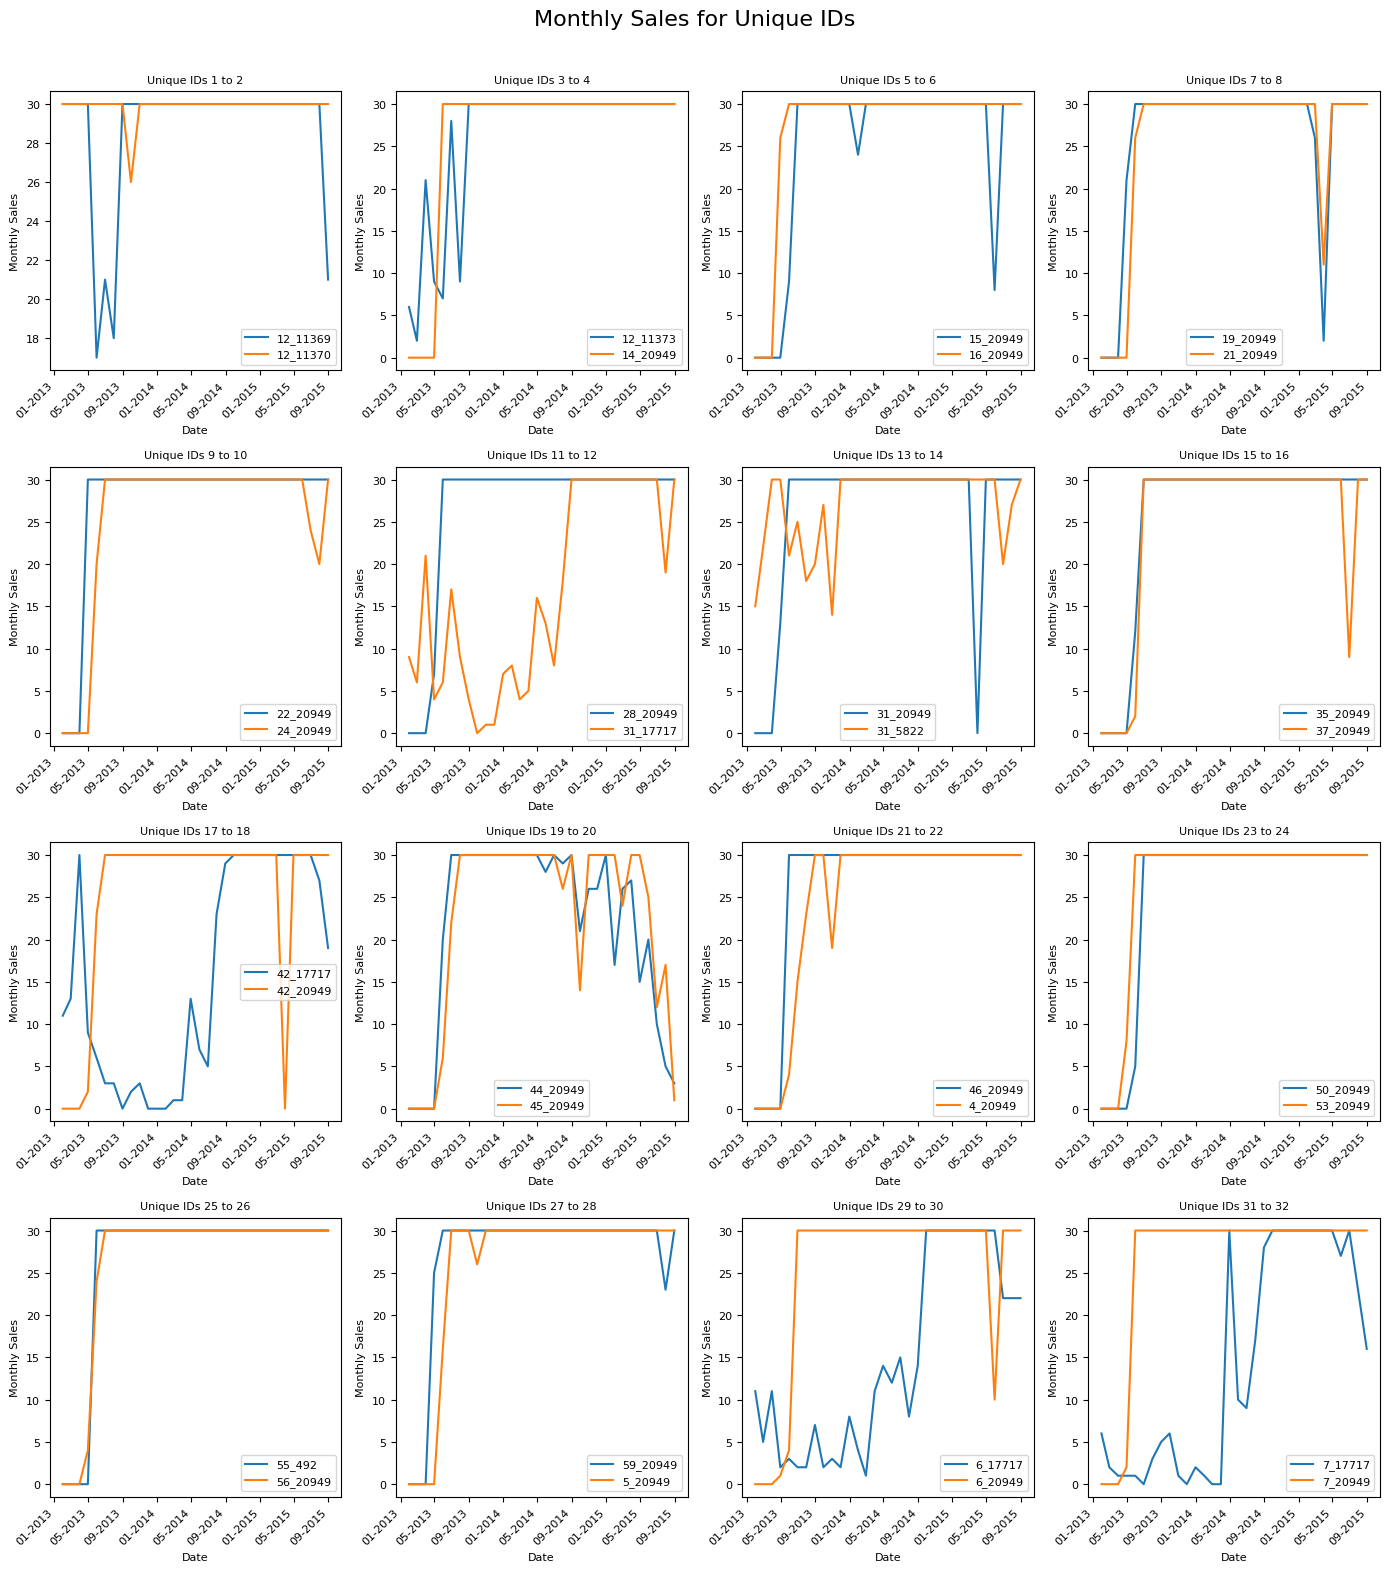

In [4817]:
plot_unique_id_series(df[df["unique_id"].isin(plateau_list+constant_list)], items_per_plot=2, plots_per_row=4)

In [4818]:
# # Iterar sobre cada unique_id en la lista combinada
# mode_flag=True
# combined_list = plateau_list + constant_list
# # Crear una lista para almacenar los resultados
# results = []
# for unique_id in combined_list:
#     # Filtrar la serie correspondiente
#     series = df[df["unique_id"] == unique_id]["monthly_sales"][:-1]
#     if mode_flag:
#         # Calcular la moda de la serie
#         prediction_value= series.mode().iloc[0] if not series.mode().empty else None
#     else:
#         # Para una serie con plateau
#         window_size = 6 # Promedio de los últimos 6 valores
#         prediction_value = series.rolling(window=window_size).mean().iloc[-1]
    
#     # Agregar el resultado a la lista
#     results.append({"unique_id": unique_id, "monthly_sales": prediction_value})

# # Convertir los resultados a un DataFrame
# predictions_df = pd.DataFrame(results)



In [4819]:
# Mostrar el DataFrame de predicciones
#predictions_df.head(3)

In [4820]:


def impute_white_noise(df, white_noise_list, method="last"):
    """
    Imputa valores en series de ruido blanco utilizando el último valor o la media.
    
    Parámetros:
    - df: DataFrame original que contiene la columna "unique_id" y "monthly_sales".
    - white_noise_list: Lista de valores únicos de unique_id que representan series de ruido blanco.
    - method: Método de imputación, "last" para el último valor o "mean" para la media. Por defecto, "last".
    
    Retorna:
    - result_df: DataFrame con columnas "unique_id" y "monthly_sales" con los valores imputados.
    """
    
    # Lista para almacenar los resultados
    results = []
    
    # Iterar sobre cada unique_id en white_noise_list
    for unique_id in white_noise_list:
        # Filtrar la serie correspondiente al unique_id actual
        series = df[df["unique_id"] == unique_id]["monthly_sales"][:-1]
        
        # Imputar el valor según el método especificado
        if method == "last":
            imputed_value = series.iloc[-1]  # Último valor de la serie
        elif method == "mean":
            imputed_value = series.mean()  # Media de la serie
        else:
            raise ValueError("El método debe ser 'last' o 'mean'")
        
        # Agregar el unique_id y el valor imputado a los resultados
        results.append({"unique_id": unique_id, "monthly_sales": imputed_value})
    
    # Convertir los resultados a un DataFrame
    result_df = pd.DataFrame(results)
    
    return result_df

# Ejemplo de uso
# df: DataFrame original con las columnas "unique_id" y "monthly_sales"
# white_noise_list: Lista de unique_id correspondientes a series de ruido blanco
# output_df = impute_white_noise(df, white_noise_list, method="last")


In [4821]:
#output_df = impute_white_noise(df, white_noise_list, method="mean")

In [4822]:
#output_df.head(4)

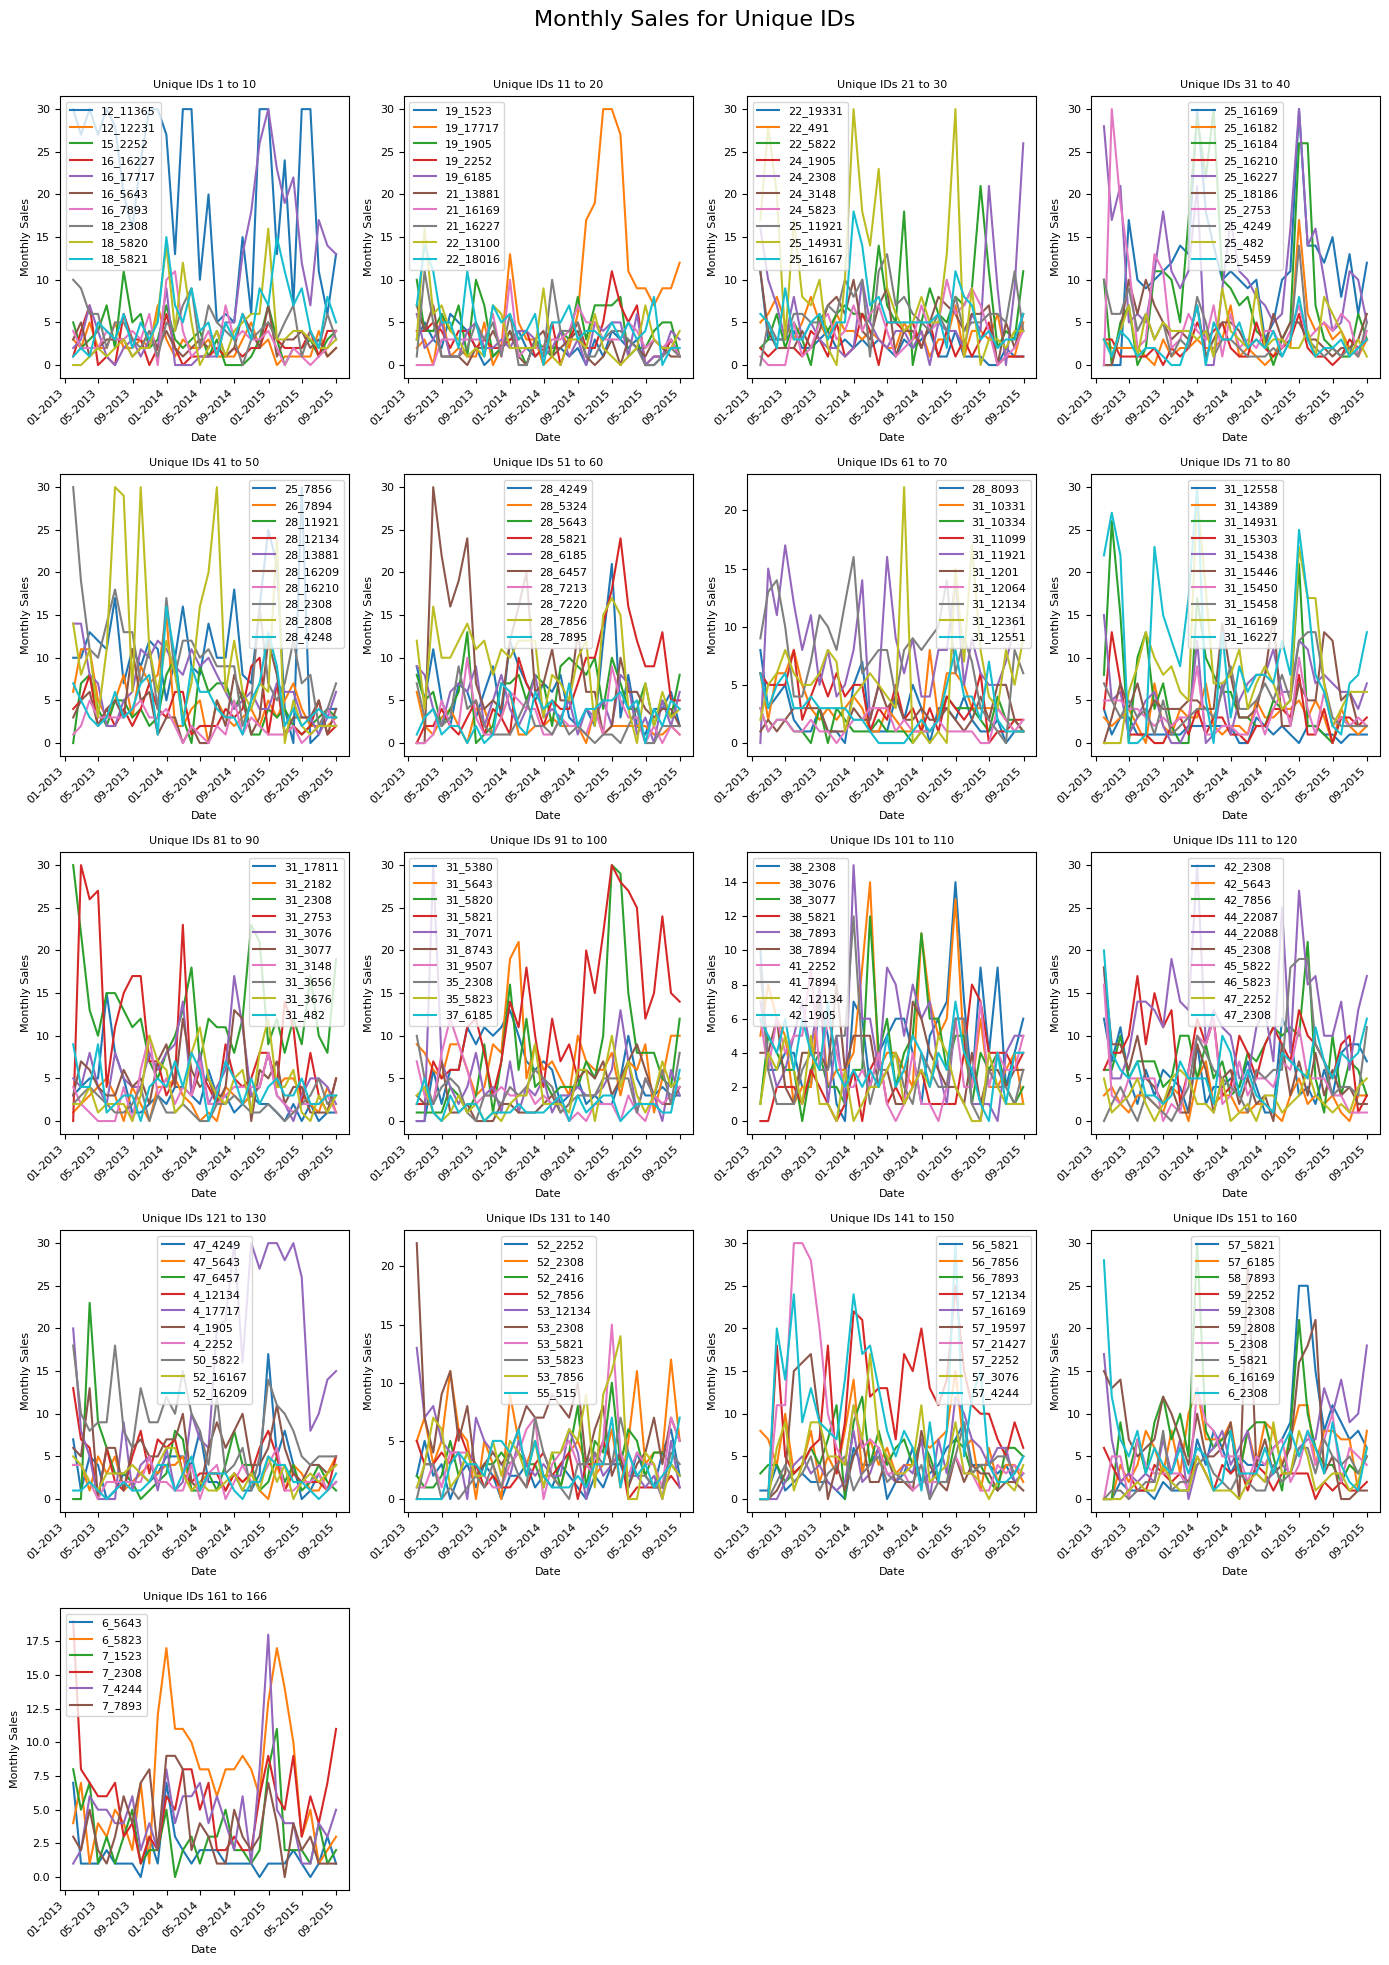

In [4823]:
plot_unique_id_series(df[df["unique_id"].isin(white_noise_list)], items_per_plot=10, plots_per_row=4)

In [4824]:
# filtered_df = df[~df["unique_id"].isin(constant_list + white_noise_list+plateau_list)]

In [4825]:
# filtered_df.head()

In [4826]:
# plot_unique_id_series(filtered_df, items_per_plot=10, plots_per_row=4)

In [4827]:
# Filtrar el DataFrame para mantener solo las filas cuyo unique_id no esté en constant_list
#df = df[~df["unique_id"].isin(constant_list+white_noise_list+plateau_list)]

In [4828]:
#df = df[~df["unique_id"].isin(constant_list+plateau_list)]

In [4829]:
# df["unique_id"].nunique()

<a id='eda'></a>
### EDA
[Volver al índice](#index)<br>

Vamos a hacer un EDA rápido para ver como son nuestras Series Temporales y coger algunas ideas para futuras variables que vamos a implementar.

Al tratarse este notebook del benchmark, vamos a explorar de manera muy superficial el dataset. En posteriores ejecuciones analizaremos el dataset en más detalle, construiremos nuevas variables y volveremos a entrenar nuestro modelo.

<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales
[Volver al índice](#index)<br>

In [4830]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [4831]:
y = df.set_index("date").resample("M")["monthly_sales"].sum()[:-1] # quitamos los registros de octubre

C:\Users\miros\AppData\Local\Temp\ipykernel_35820\3920371324.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = df.set_index("date").resample("M")["monthly_sales"].sum()[:-1] # quitamos los registros de octubre


In [4832]:
adf_res=adfuller(y)
print(adf_res[0],adf_res[1])

-4.224501771695339 0.0005987235975231102


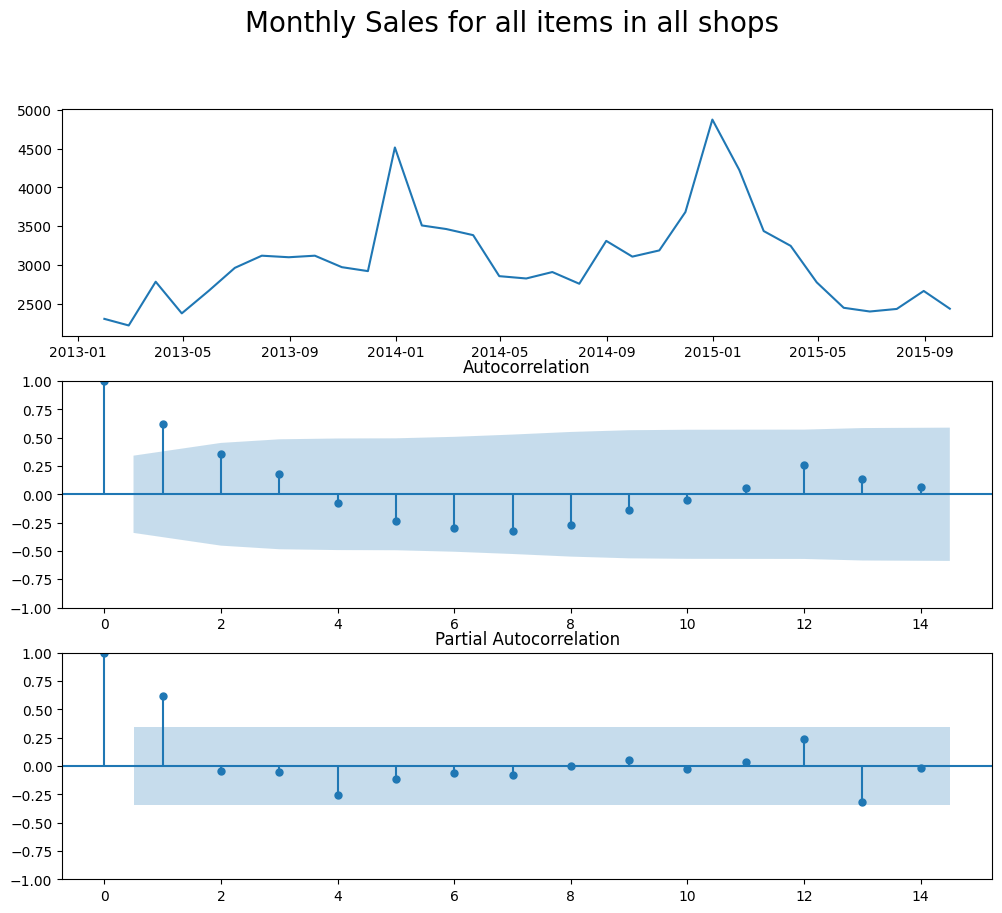

In [4833]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

Nota importante: nos estamos ayudando del gráfico de acf y pacf, pero no vamos a entrenar un modelo ARIMA.

Para resolver el problema que se nos plantea: más de 400 Series Temporales diferentes tendríamos que entrenar 400 ARIMAs (1 modelo por Serie Temporal). En cambio, con el algoritmo de XGBoost podríamos entrenar 1 único modelo.

Ahora bien, al contrario que ARIMA (que internamente construye las variables necesarias), para XGBoost debemos ser explícitos y suministrarle todas y cada una de las variables necesarias.

Del gráfico anterior ya podemos observar que las variables de lags pueden ser muy relevantes.

IDEA para los alumnos: podéis intentar analizar algunas de las 400 Series Temporales de manera individual para ver su comportamiento.

<a id='eda_top_3_cities'></a>
### --> 2. EDA: Top 3 Cities
[Volver al índice](#index)<br>

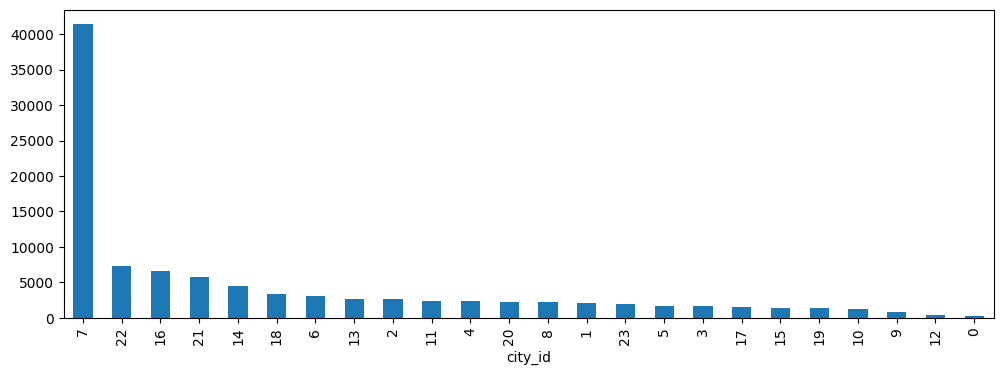

In [4834]:
(
    df.
    groupby(["city_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='eda_top_3_categories'></a>
### --> 3. EDA: Top 3 Categories
[Volver al índice](#index)<br>

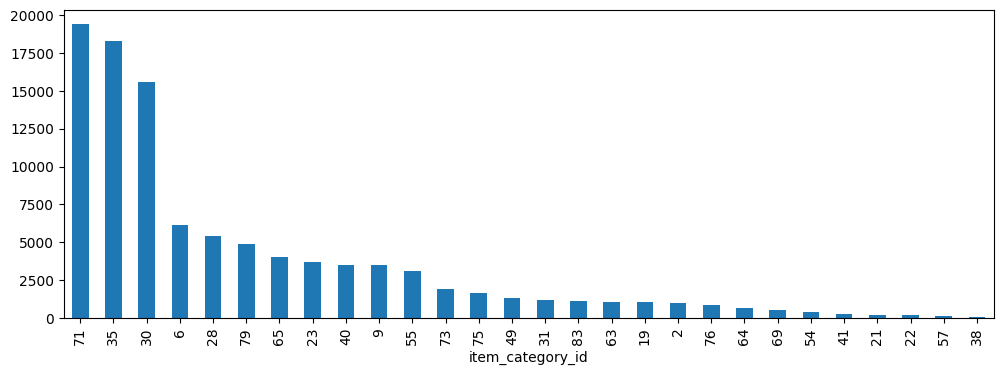

In [4835]:
(
    df.
    groupby(["item_category_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

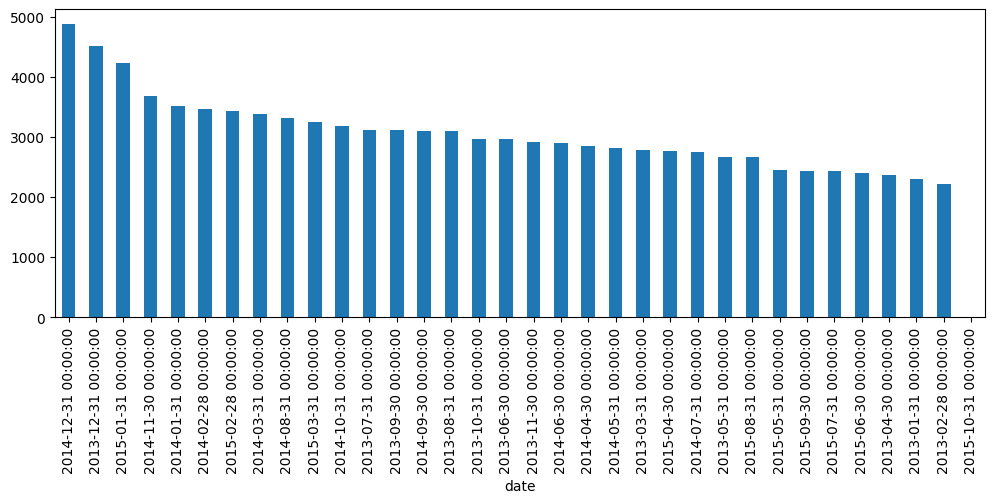

In [4836]:
# Numero de ventas por mes
(
    df.
    groupby(["date"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

In [4837]:
# Pregunta 6
df.groupby(["date"])["monthly_sales"].sum().sort_values(ascending = False).head(1)

date
2014-12-31    4874.0
Name: monthly_sales, dtype: float64

<a id='build_ts_features'></a>
### Build Time Series Features (**CORE IDEA**)
[Volver al índice](#index)<br>

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo el código encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene más de 400 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ventas totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [4838]:
df["revenue"] = df["monthly_average_price"] * df["monthly_sales"]
df1["revenue"] = df1["monthly_average_price"] * df1["monthly_sales"]

In [4839]:
# Pregunta 8
# dfaux8=df.groupby(["date","item_category_id"])["revenue"].sum().sort_values(ascending = False).reset_index()
# dfaux8[dfaux8["date"]=="2015-09-30"].head(1)

In [4840]:
# # Pregunta 9
# category_with_most_unique_items = (
#     df.groupby("item_category_id")["item_id"].nunique().sort_values(ascending=False).reset_index()
# )
# category_with_most_unique_items.head(1)

In [4841]:
# # Pregunta 10
# monthly_sales_moving_avg = (
#     df
#     .assign(date=pd.to_datetime(df['date']))  # Asegurar que 'date' esté en formato datetime
#     .groupby(df['date'].dt.to_period("M"))["monthly_sales"]
#     .sum()  # Agrupar y sumar las ventas mensuales
#     .to_timestamp()  # Convertir el índice de periodo a fecha
#     .rolling(window=3)
#     .mean()  # Calcular la media móvil de 3 meses
#     .reset_index(name="3_months_moving_avg")
#     .sort_values(by="date")  # Restablecer el índice y renombrar la columna
# )
# monthly_sales_moving_avg.head(10)

In [4842]:
df.head(3)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143


In [4843]:
# Transformación cíclica del mes
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 12)
# df1['month_sin'] = np.sin(2 * np.pi * df1['date'].dt.month / 12)
# df1['month_cos'] = np.cos(2 * np.pi * df1['date'].dt.month / 12)
df['year'] = df['date'].dt.year
# # probar trimestre
# df['quarter_sin'] = np.sin(2 * np.pi * df['date'].dt.quarter / 4)
# df['quarter_cos'] = np.cos(2 * np.pi * df['date'].dt.quarter / 4)

In [4844]:
df.head(3)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,month_sin,month_cos,year
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,0.500000,8.660254e-01,2013
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,0.866025,5.000000e-01,2013
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,1.000000,6.123234e-17,2013


In [4845]:
# df["monthly_sales_ma2"]=(df
#                             .groupby("unique_id")["monthly_average_price"]
#                             .transform(lambda series: series.shift(1).rolling(window = 2).mean()))
# df["monthly_sales_ma3"]=(df
#                             .groupby("unique_id")["monthly_average_price"]
#                             .transform(lambda series: series.shift(1).rolling(window = 3).mean()))

# df["monthly_sales_ma6"]=(df
#                             .groupby("unique_id")["monthly_average_price"]
#                             .transform(lambda series: series.shift(1).rolling(window = 6).mean()))
# df["monthly_sales_ma12"]=(df
#                             .groupby("unique_id")["monthly_average_price"]
#                            .transform(lambda series: series.shift(1).rolling(window = 12).mean()))

In [4846]:
# df["monthly_sales_pct_change"] = (
#    df.groupby("unique_id")["monthly_sales"].transform(lambda x: x.shift(1).pct_change())
# )

In [4847]:
# Cambio en precio
# df["monthly_average_price_diff1"]=(df
#                                    .groupby("unique_id")["monthly_average_price"]
#                                    .transform(lambda series: series.diff()))

In [4848]:
df["revenue_pct_change"] = (
   df.groupby("unique_id")["revenue"].transform(lambda x: x.shift(1).pct_change())
)

In [4849]:
for lag in [1, 3, 6]:
    df[f"revenue_lag{lag}"] = df.groupby("unique_id")["revenue"].shift(lag)

In [4850]:
# empeora
#df["monthly_sales_delta_2"] = df.groupby("unique_id")["monthly_sales"].shift(1).diff(2)

In [4851]:
# empeora
# for window in [3, 6, 12]:
#     df[f"revenue_ma{window}"] = df.groupby("unique_id")["revenue"].transform(lambda x: x.shift(1).rolling(window).mean())

In [4852]:

#df["monthly_sales_delta_3"] = df.groupby("unique_id")["monthly_sales"].shift(1).diff(3)

In [4853]:
# empeora
#  df["revenue_delta_1"] = df.groupby("unique_id")["revenue"].shift(1).diff(1)

In [4854]:

# df["revenue_delta_3"] = df.groupby("unique_id")["revenue"].shift(1).diff(3)

In [4855]:
# empeora 
# df["revenue_delta_2"] = df.groupby("unique_id")["revenue"].shift(1).diff(2)

In [4856]:
# empeora 
#df["price_sales_ratio"] = (df["monthly_average_price"] / (df["monthly_sales"] + 1)).shift(1)

In [4857]:
# empeora
for window in [3,6,12]:
     df[f"monthly_sales_ma{window}"] = df.groupby("unique_id")["monthly_sales"].transform(lambda x: x.shift(1).rolling(window).mean())

In [4858]:
df.head(3)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,month_sin,month_cos,year,revenue_pct_change,revenue_lag1,revenue_lag3,revenue_lag6,monthly_sales_ma3,monthly_sales_ma6,monthly_sales_ma12
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,0.500000,8.660254e-01,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,0.866025,5.000000e-01,2013,NaN,45345.378788,NaN,NaN,NaN,NaN,NaN
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,1.000000,6.123234e-17,2013,-0.087131,41394.375000,NaN,NaN,NaN,NaN,NaN


In [4859]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name, nr_lags, ma=False):
    
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("ME")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
     
    for lag in range(nr_lags):
        gb_df_[f"{new_name}_lag{lag + 1}"] = gb_df_.groupby(gb_list)[new_name].transform(
            lambda series: series.shift(lag + 1)
        )
    if ma:
        for window in [3,6,12]:
            gb_df_[f"{new_name}_ma{window}"] = gb_df_.groupby(gb_list)[new_name].transform(
                lambda series: series.shift(1).rolling(window=window).mean()
            )    
    
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)
    
    return gb_df_

In [4860]:
df.head(3)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,month_sin,month_cos,year,revenue_pct_change,revenue_lag1,revenue_lag3,revenue_lag6,monthly_sales_ma3,monthly_sales_ma6,monthly_sales_ma12
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,0.500000,8.660254e-01,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,0.866025,5.000000e-01,2013,NaN,45345.378788,NaN,NaN,NaN,NaN,NaN
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,1.000000,6.123234e-17,2013,-0.087131,41394.375000,NaN,NaN,NaN,NaN,NaN


In [4861]:
df1[df1["item_id"]== 32].head(3)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue
5663,2013-01-31,31_32,7,31,40,32,349.0,24.0,8376.0
5740,2013-02-28,31_32,7,31,40,32,349.0,20.0,6980.0
5817,2013-03-31,31_32,7,31,40,32,349.0,13.0,4537.0


In [4862]:
vars_item_id = build_ts_vars(
    df = df,
    gb_list = ["item_id"],
    target_column = "monthly_sales",
    agg_func = np.sum,
    agg_func_name =  "sum",
    nr_lags = 3,
    ma=False
    
)

vars_shop_item_revenue = build_ts_vars(
    df = df,
    gb_list = ["shop_id", "item_id"],
    target_column = "revenue",
    agg_func = np.sum,
    agg_func_name =  "sum",
    nr_lags = 3,
    ma=True
    
)

# vars_shop_item_monthly_average_price = build_ts_vars(
#     df = df,
#     gb_list = ["shop_id", "item_id"],
#     target_column = "monthly_average_price",
#     agg_func = np.mean,
#     agg_func_name =  "mean",
#     nr_lags = 1,
#     ma=False
    
# )

vars_shop_category_item_monthly_sales = build_ts_vars(
     df = df,
     gb_list = ["shop_id","item_category_id"],
     target_column = "monthly_sales",
     agg_func = np.sum,
     agg_func_name =  "sum",
     nr_lags = 3,
     ma=False
 )

# vars_city_monthly_sales_avg = build_ts_vars(
#     df = df,
#     gb_list = ["city_id"],
#     target_column = "monthly_sales",
#     agg_func = np.mean,
#     agg_func_name =  "mean",
#     nr_lags = 3,
#     ma=False
    
# )



# vars_shop_category_item_revenue = build_ts_vars(
#     df = df,
#     gb_list = ["shop_id", "item_category_id"],
#     target_column = "revenue",
#     agg_func = np.sum,
#     agg_func_name =  "sum",
#     nr_lags = 3,
#     ma=False
    
# )





C:\Users\miros\AppData\Local\Temp\ipykernel_35820\4147434256.py:12: FutureWarning: The provided callable <function sum at 0x0000025176D4B240> is currently using DatetimeIndexResamplerGroupby.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .apply(agg_func)


Dropping columns that might cause target leakage item_id_monthly_sales_sum


C:\Users\miros\AppData\Local\Temp\ipykernel_35820\4147434256.py:12: FutureWarning: The provided callable <function sum at 0x0000025176D4B240> is currently using DatetimeIndexResamplerGroupby.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .apply(agg_func)


Dropping columns that might cause target leakage shop_id_item_id_revenue_sum


C:\Users\miros\AppData\Local\Temp\ipykernel_35820\4147434256.py:12: FutureWarning: The provided callable <function sum at 0x0000025176D4B240> is currently using DatetimeIndexResamplerGroupby.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .apply(agg_func)


Dropping columns that might cause target leakage shop_id_item_category_id_monthly_sales_sum


In [4863]:
vars_shop_item_revenue.head(5)

,shop_id,item_id,date,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3,shop_id_item_id_revenue_sum_ma3,shop_id_item_id_revenue_sum_ma6,shop_id_item_id_revenue_sum_ma12
0,3,5822,2013-01-31,NaN,NaN,NaN,NaN,NaN,NaN
1,3,5822,2013-02-28,999.0,NaN,NaN,NaN,NaN,NaN
2,3,5822,2013-03-31,999.0,999.0,NaN,NaN,NaN,NaN
3,3,5822,2013-04-30,1049.0,999.0,999.0,1015.666667,NaN,NaN
4,3,5822,2013-05-31,1048.5,1049.0,999.0,1032.166667,NaN,NaN


In [4864]:
vars_item_id.head(5)

,item_id,date,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3
0,32,2013-01-31,NaN,NaN,NaN
1,32,2013-02-28,24.0,NaN,NaN
2,32,2013-03-31,20.0,24.0,NaN
3,32,2013-04-30,13.0,20.0,24.0
4,32,2013-05-31,11.0,13.0,20.0


In [4865]:
vars_shop_category_item_monthly_sales.head(3)

,shop_id,item_category_id,date,shop_id_item_category_id_monthly_sales_sum_lag1,shop_id_item_category_id_monthly_sales_sum_lag2,shop_id_item_category_id_monthly_sales_sum_lag3
0,3,6,2013-01-31,NaN,NaN,NaN
1,3,6,2013-02-28,1.0,NaN,NaN
2,3,6,2013-03-31,0.0,1.0,NaN


In [4866]:
# vars_shop_item_revenue.head()

<a id='join_ts_features'></a>
### Join TS Features
[Volver al índice](#index)<br>

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano.

In [4867]:
print(df.shape)

df = pd.merge(df, vars_item_id, on = ["date", "item_id"], how = "left")
df = pd.merge(df, vars_shop_item_revenue, on = ["date", "shop_id", "item_id"], how = "left")
df = pd.merge(df, vars_shop_category_item_monthly_sales, on = ["date", "shop_id", "item_category_id"], how = "left")
#df = pd.merge(df, vars_shop_item_monthly_average_price,on = ["date", "shop_id", "item_id"], how = "left")

#df1 = pd.merge(df1, vars_item_id, on = ["date", "item_id"], how = "left")
#df1 = pd.merge(df1, vars_shop_item_revenue, on = ["date", "shop_id", "item_id"], how = "left")

print(df.shape)

(14484, 19)
(14484, 31)


In [4868]:
df.head(3)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,month_sin,month_cos,year,revenue_pct_change,revenue_lag1,revenue_lag3,revenue_lag6,monthly_sales_ma3,monthly_sales_ma6,monthly_sales_ma12,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3,shop_id_item_id_revenue_sum_ma3,shop_id_item_id_revenue_sum_ma6,shop_id_item_id_revenue_sum_ma12,shop_id_item_category_id_monthly_sales_sum_lag1,shop_id_item_category_id_monthly_sales_sum_lag2,shop_id_item_category_id_monthly_sales_sum_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,0.500000,8.660254e-01,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,0.866025,5.000000e-01,2013,NaN,45345.378788,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,45345.378788,NaN,NaN,NaN,NaN,NaN,96.0,NaN,NaN
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,1.000000,6.123234e-17,2013,-0.087131,41394.375000,NaN,NaN,NaN,NaN,NaN,27.0,30.0,NaN,41394.375000,45345.378788,NaN,NaN,NaN,NaN,89.0,96.0,NaN


In [4869]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.fillna(0, inplace=True)

In [4870]:
df1[df1["item_id"]==5822].head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue
241,2013-01-31,14_5822,3,14,35,5822,999.0,1.0,999.0
247,2013-02-28,14_5822,3,14,35,5822,1049.0,4.0,4196.0
253,2013-03-31,14_5822,3,14,35,5822,1049.0,4.0,4196.0
259,2013-04-30,14_5822,3,14,35,5822,1049.0,9.0,9441.0
265,2013-05-31,14_5822,3,14,35,5822,1049.0,6.0,6294.0


# ENTRENAMOS SIEMPRE CON EL PASADO

In [4871]:
df.head(3)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,month_sin,month_cos,year,revenue_pct_change,revenue_lag1,revenue_lag3,revenue_lag6,monthly_sales_ma3,monthly_sales_ma6,monthly_sales_ma12,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3,shop_id_item_id_revenue_sum_ma3,shop_id_item_id_revenue_sum_ma6,shop_id_item_id_revenue_sum_ma12,shop_id_item_category_id_monthly_sales_sum_lag1,shop_id_item_category_id_monthly_sales_sum_lag2,shop_id_item_category_id_monthly_sales_sum_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,0.500000,8.660254e-01,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,0.866025,5.000000e-01,2013,NaN,45345.378788,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,45345.378788,NaN,NaN,NaN,NaN,NaN,96.0,NaN,NaN
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,1.000000,6.123234e-17,2013,-0.087131,41394.375000,NaN,NaN,NaN,NaN,NaN,27.0,30.0,NaN,41394.375000,45345.378788,NaN,NaN,NaN,NaN,89.0,96.0,NaN


C:\Users\miros\AppData\Local\Temp\ipykernel_35820\1997102359.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = corr_matrix.applymap(lambda x: f'{x:.2f}' if abs(x) > filter_threshold else '')


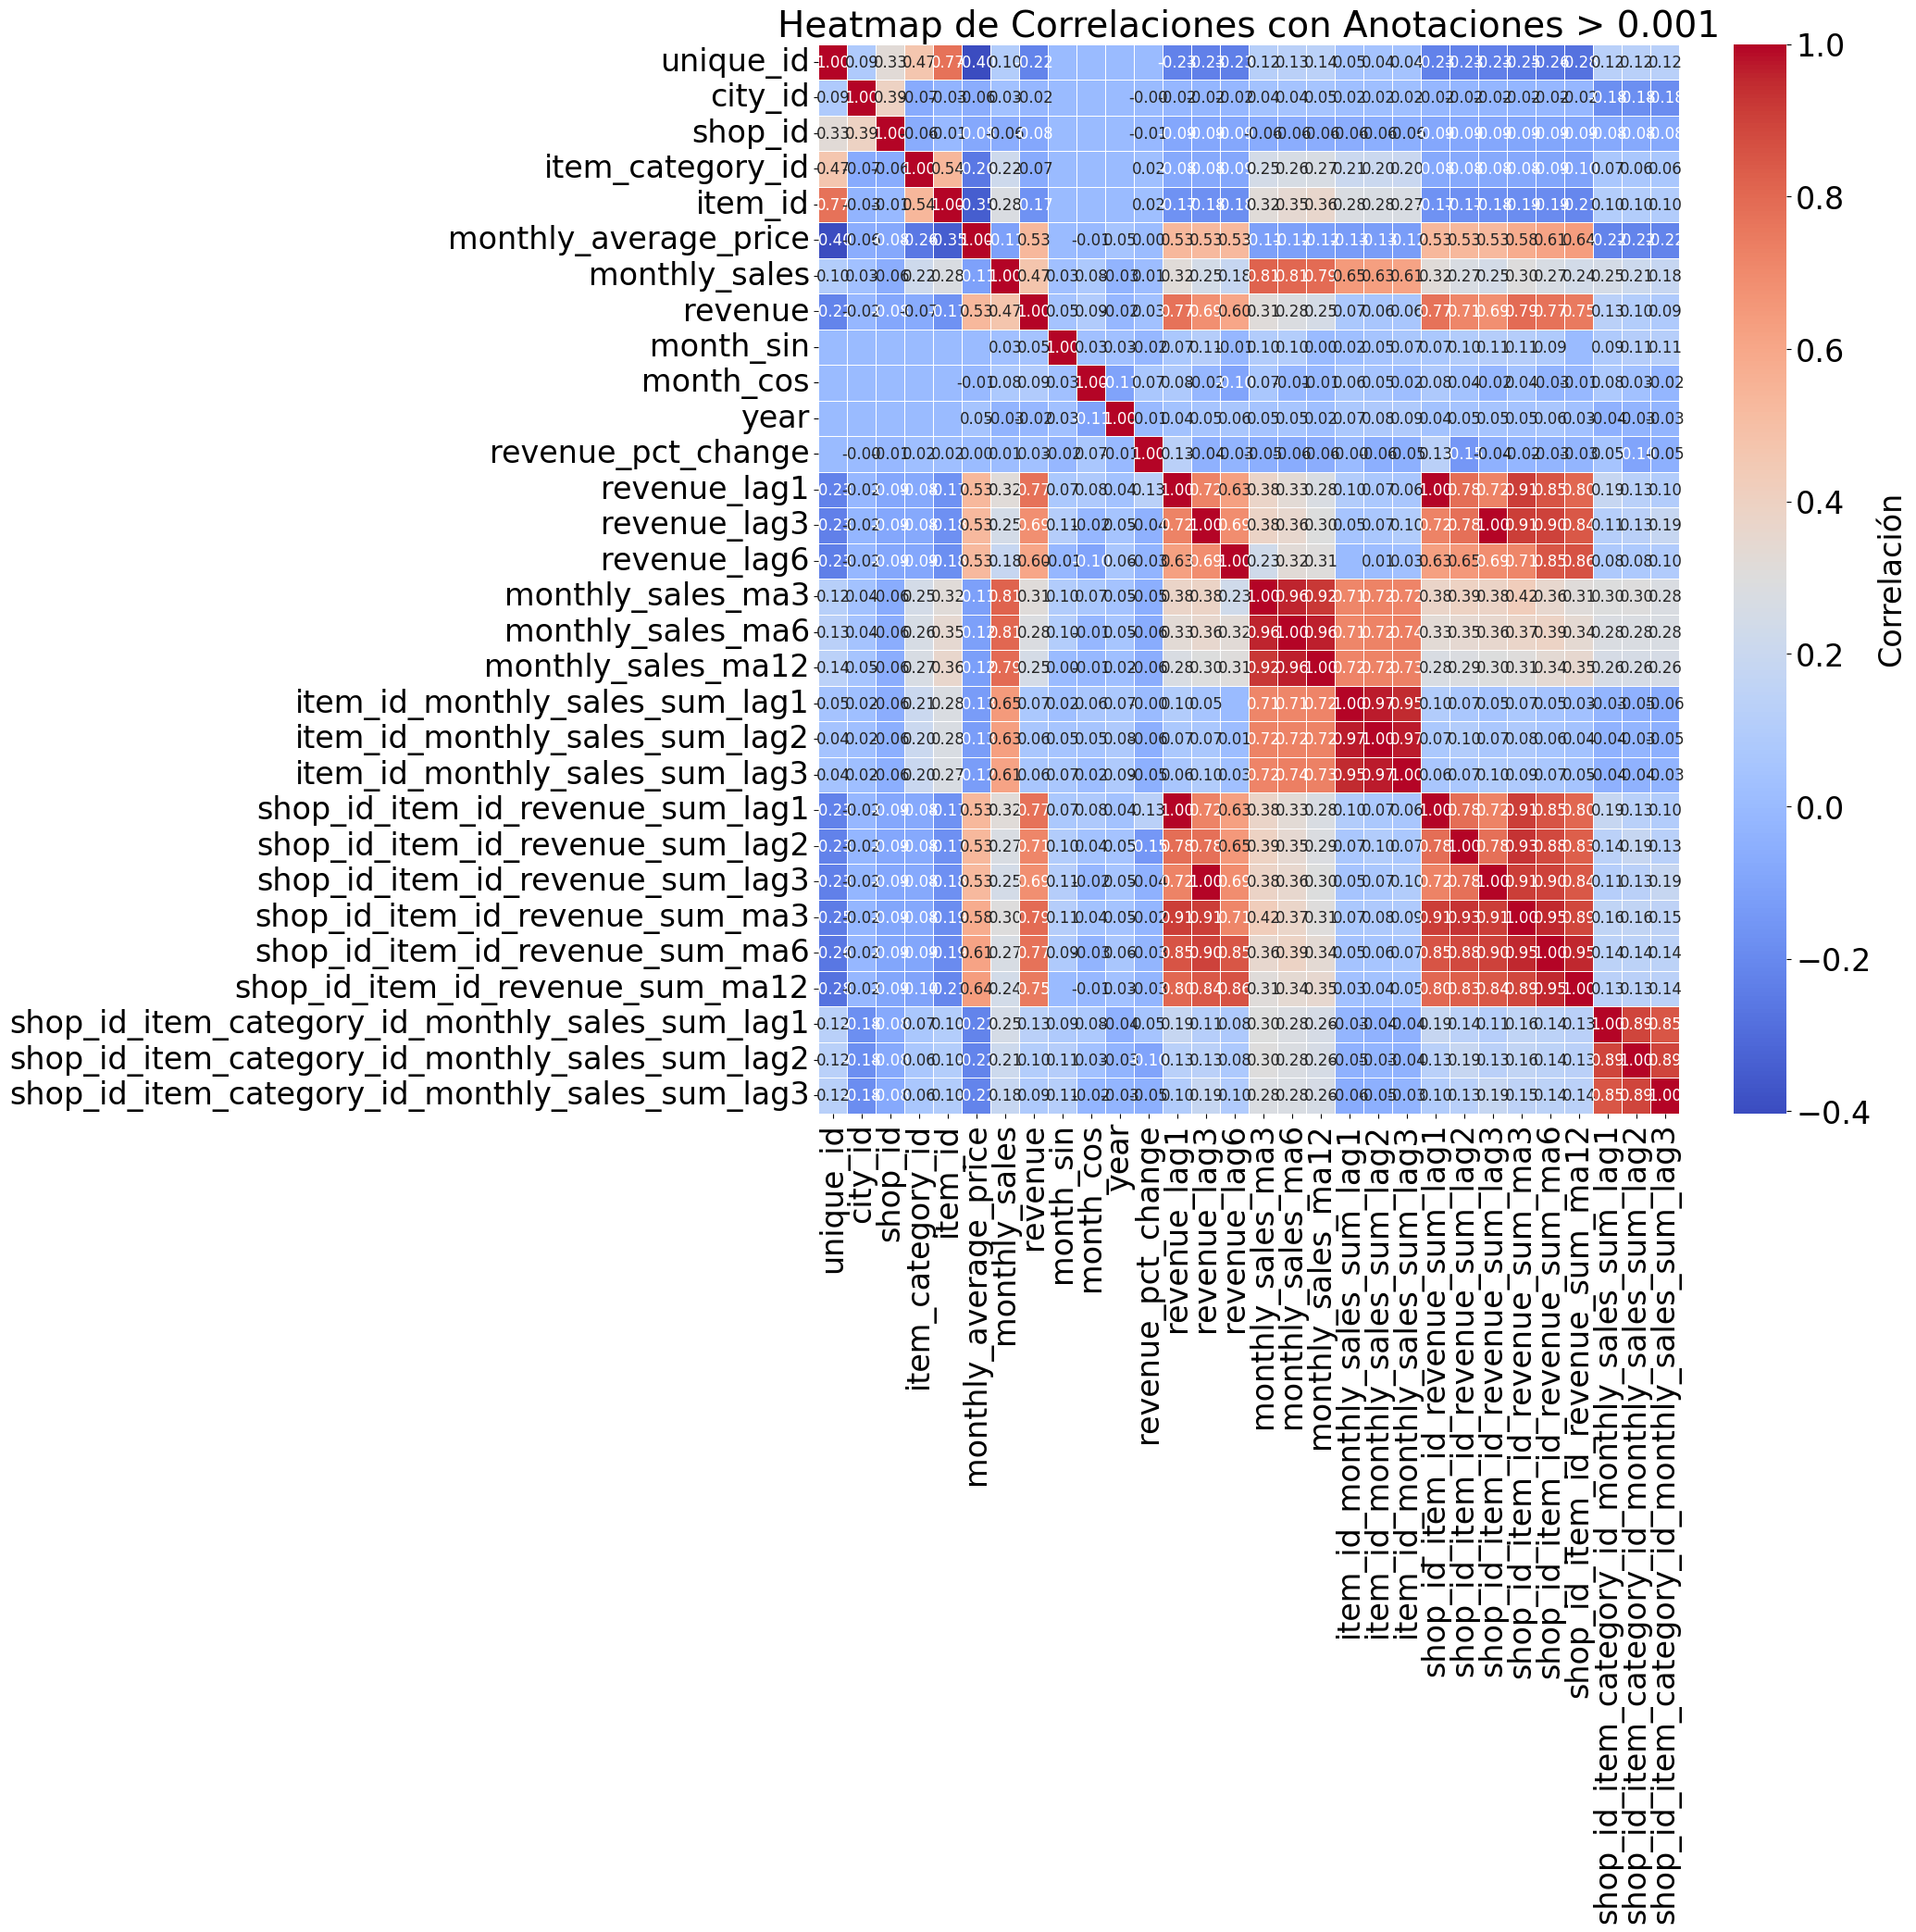

Columns to drop: ['item_id_monthly_sales_sum_lag2', 'item_id_monthly_sales_sum_lag3']


In [4872]:
# Mirar correlacion
df_ax=df.drop("date",axis=1)
cols_to_drop=plot_correlation_and_find_columns_to_drop(df_ax, df_ax.columns, target_col='monthly_sales',drop_threshold=0.97)
print(f"Columns to drop: {cols_to_drop}")
#df = df.drop(cols_to_drop, axis=1)


In [4873]:
df.columns

Index(['date', 'unique_id', 'city_id', 'shop_id', 'item_category_id',
       'item_id', 'monthly_average_price', 'monthly_sales', 'revenue',
       'month_sin', 'month_cos', 'year', 'revenue_pct_change', 'revenue_lag1',
       'revenue_lag3', 'revenue_lag6', 'monthly_sales_ma3',
       'monthly_sales_ma6', 'monthly_sales_ma12',
       'item_id_monthly_sales_sum_lag1', 'item_id_monthly_sales_sum_lag2',
       'item_id_monthly_sales_sum_lag3', 'shop_id_item_id_revenue_sum_lag1',
       'shop_id_item_id_revenue_sum_lag2', 'shop_id_item_id_revenue_sum_lag3',
       'shop_id_item_id_revenue_sum_ma3', 'shop_id_item_id_revenue_sum_ma6',
       'shop_id_item_id_revenue_sum_ma12',
       'shop_id_item_category_id_monthly_sales_sum_lag1',
       'shop_id_item_category_id_monthly_sales_sum_lag2',
       'shop_id_item_category_id_monthly_sales_sum_lag3'],
      dtype='object')

C:\Users\miros\AppData\Local\Temp\ipykernel_35820\1997102359.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = corr_matrix.applymap(lambda x: f'{x:.2f}' if abs(x) > filter_threshold else '')


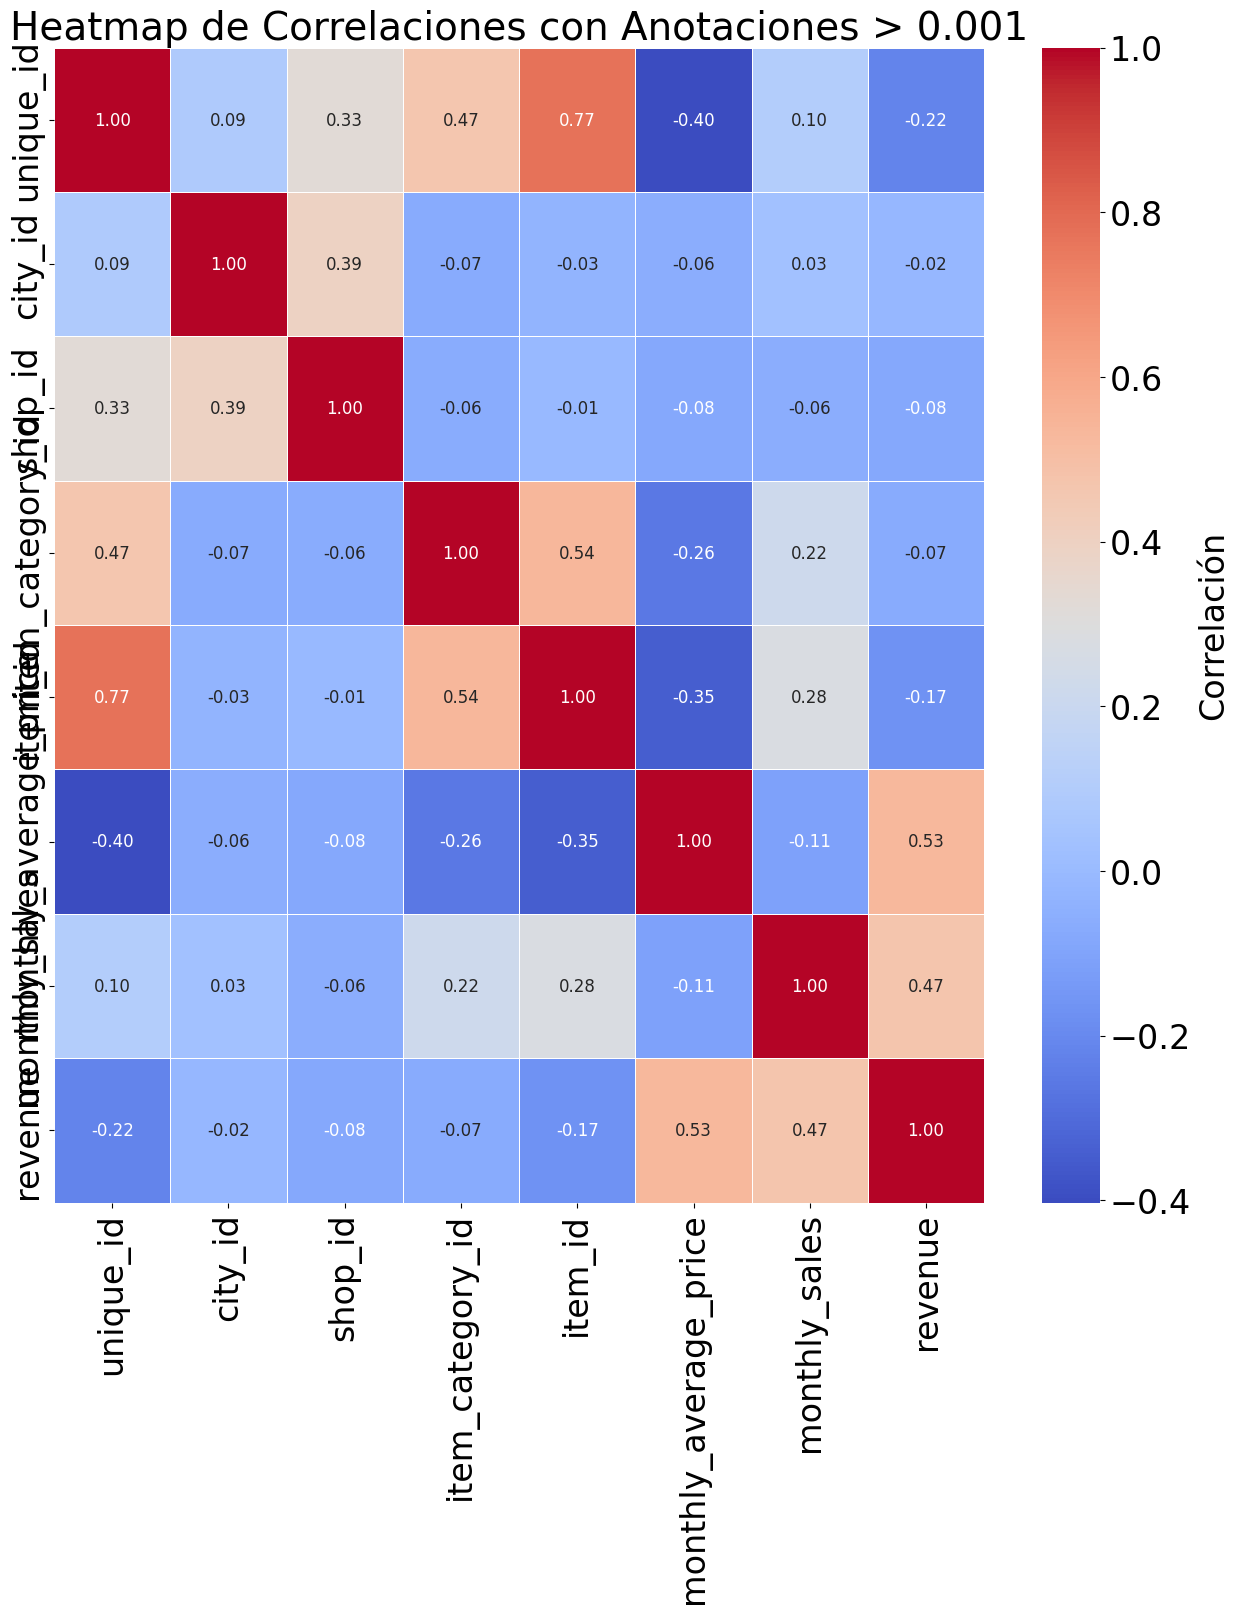

Columns to drop: []


In [4874]:
# Mirar correlacion
df_ax1=df1.drop("date",axis=1)
cols_to_drop1=plot_correlation_and_find_columns_to_drop(df_ax1, df_ax1.columns, target_col='monthly_sales',drop_threshold=0.96)
print(f"Columns to drop: {cols_to_drop1}")
#df1 = df1.drop(cols_to_drop1, axis=1)

In [4875]:
df1.columns

Index(['date', 'unique_id', 'city_id', 'shop_id', 'item_category_id',
       'item_id', 'monthly_average_price', 'monthly_sales', 'revenue'],
      dtype='object')

<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [4876]:
df.columns.tolist()

['date',
 'unique_id',
 'city_id',
 'shop_id',
 'item_category_id',
 'item_id',
 'monthly_average_price',
 'monthly_sales',
 'revenue',
 'month_sin',
 'month_cos',
 'year',
 'revenue_pct_change',
 'revenue_lag1',
 'revenue_lag3',
 'revenue_lag6',
 'monthly_sales_ma3',
 'monthly_sales_ma6',
 'monthly_sales_ma12',
 'item_id_monthly_sales_sum_lag1',
 'item_id_monthly_sales_sum_lag2',
 'item_id_monthly_sales_sum_lag3',
 'shop_id_item_id_revenue_sum_lag1',
 'shop_id_item_id_revenue_sum_lag2',
 'shop_id_item_id_revenue_sum_lag3',
 'shop_id_item_id_revenue_sum_ma3',
 'shop_id_item_id_revenue_sum_ma6',
 'shop_id_item_id_revenue_sum_ma12',
 'shop_id_item_category_id_monthly_sales_sum_lag1',
 'shop_id_item_category_id_monthly_sales_sum_lag2',
 'shop_id_item_category_id_monthly_sales_sum_lag3']

In [4877]:
COLUMNS_TO_DROP = [
   "revenue",#"monthly_average_price"
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [4878]:
df1.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [4879]:
df.set_index("unique_id", inplace = True)
df1.set_index("unique_id", inplace = True)

In [4880]:
df.head(3)

,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,month_sin,month_cos,year,revenue_pct_change,revenue_lag1,revenue_lag3,revenue_lag6,monthly_sales_ma3,monthly_sales_ma6,monthly_sales_ma12,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3,shop_id_item_id_revenue_sum_ma3,shop_id_item_id_revenue_sum_ma6,shop_id_item_id_revenue_sum_ma12,shop_id_item_category_id_monthly_sales_sum_lag1,shop_id_item_category_id_monthly_sales_sum_lag2,shop_id_item_category_id_monthly_sales_sum_lag3
unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12_11365,2013-01-31,16,12,9,11365,1511.512626,30.0,0.500000,8.660254e-01,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12_11365,2013-02-28,16,12,9,11365,1533.125000,27.0,0.866025,5.000000e-01,2013,NaN,45345.378788,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,45345.378788,NaN,NaN,NaN,NaN,NaN,96.0,NaN,NaN
12_11365,2013-03-31,16,12,9,11365,3252.470238,30.0,1.000000,6.123234e-17,2013,-0.087131,41394.375000,NaN,NaN,NaN,NaN,NaN,27.0,30.0,NaN,41394.375000,45345.378788,NaN,NaN,NaN,NaN,89.0,96.0,NaN


In [4881]:
df1.head(3)

,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
unique_id,,,,,,,
12_11365,2013-01-31,16,12,9,11365,1511.512626,30.0
12_11365,2013-02-28,16,12,9,11365,1533.125000,27.0
12_11365,2013-03-31,16,12,9,11365,3252.470238,30.0


In [4882]:
train_index = sorted(list(df["date"].unique()))[:-2]

valida_index = [sorted(list(df["date"].unique()))[-2]]

test_index = [sorted(list(df["date"].unique()))[-1]]

In [4883]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-31 00:00:00')]

Our validation index is [Timestamp('2015-09-30 00:00:00')]

Our test/prediction index is [Timestamp('2015-10-31 00:00:00')]



In [4884]:
X_train = df[df["date"].isin(train_index)].drop(['monthly_sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['monthly_sales']

X_valida = df[df["date"].isin(valida_index)].drop(['monthly_sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['monthly_sales']

X_test = df[df["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['monthly_sales']

In [4885]:
X_train_df1 = df1[df1["date"].isin(train_index)].drop(['monthly_sales', "date"], axis=1)
Y_train_df1 = df1[df1["date"].isin(train_index)]['monthly_sales']

X_valida_df1 = df1[df1["date"].isin(valida_index)].drop(['monthly_sales', "date"], axis=1)
Y_valida_df1 = df1[df1["date"].isin(valida_index)]['monthly_sales']

X_test_df1 = df1[df1["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
Y_test_df1 = df1[df1["date"].isin(test_index)]['monthly_sales']

In [4886]:
X_train.head(3)

,city_id,shop_id,item_category_id,item_id,monthly_average_price,month_sin,month_cos,year,revenue_pct_change,revenue_lag1,revenue_lag3,revenue_lag6,monthly_sales_ma3,monthly_sales_ma6,monthly_sales_ma12,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3,shop_id_item_id_revenue_sum_ma3,shop_id_item_id_revenue_sum_ma6,shop_id_item_id_revenue_sum_ma12,shop_id_item_category_id_monthly_sales_sum_lag1,shop_id_item_category_id_monthly_sales_sum_lag2,shop_id_item_category_id_monthly_sales_sum_lag3
unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,1511.512626,0.500000,8.660254e-01,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,1533.125000,0.866025,5.000000e-01,2013,NaN,45345.378788,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,45345.378788,NaN,NaN,NaN,NaN,NaN,96.0,NaN,NaN
12_11365,16,12,9,11365,3252.470238,1.000000,6.123234e-17,2013,-0.087131,41394.375000,NaN,NaN,NaN,NaN,NaN,27.0,30.0,NaN,41394.375000,45345.378788,NaN,NaN,NaN,NaN,89.0,96.0,NaN


In [4887]:
Y_train.head(3)

unique_id
12_11365    30.0
12_11365    27.0
12_11365    30.0
Name: monthly_sales, dtype: float64

In [4888]:
X_train.columns

Index(['city_id', 'shop_id', 'item_category_id', 'item_id',
       'monthly_average_price', 'month_sin', 'month_cos', 'year',
       'revenue_pct_change', 'revenue_lag1', 'revenue_lag3', 'revenue_lag6',
       'monthly_sales_ma3', 'monthly_sales_ma6', 'monthly_sales_ma12',
       'item_id_monthly_sales_sum_lag1', 'item_id_monthly_sales_sum_lag2',
       'item_id_monthly_sales_sum_lag3', 'shop_id_item_id_revenue_sum_lag1',
       'shop_id_item_id_revenue_sum_lag2', 'shop_id_item_id_revenue_sum_lag3',
       'shop_id_item_id_revenue_sum_ma3', 'shop_id_item_id_revenue_sum_ma6',
       'shop_id_item_id_revenue_sum_ma12',
       'shop_id_item_category_id_monthly_sales_sum_lag1',
       'shop_id_item_category_id_monthly_sales_sum_lag2',
       'shop_id_item_category_id_monthly_sales_sum_lag3'],
      dtype='object')

In [4889]:
X_train_df1.columns

Index(['city_id', 'shop_id', 'item_category_id', 'item_id',
       'monthly_average_price'],
      dtype='object')

<a id='model_train'></a>
### Model Train
[Volver al índice](#index)<br>

Entrenamos nuestro modelo de Machine Learning (benchmark).

In [4890]:
from catboost import CatBoostRegressor

# Crear el modelo CatBoost con parámetros equivalentes
model = CatBoostRegressor(random_seed=3,verbose=True,loss_function="RMSE",iterations=2413,learning_rate=0.03,use_best_model=False )

#model = CatBoostRegressor(random_seed=3,verbose=True,loss_function="RMSE",iterations=2413,learning_rate=0.03,use_best_model=False )
#model = CatBoostRegressor(random_seed=175,verbose=True,loss_function="RMSE",iterations=993,learning_rate=0.03,use_best_model=False )
#model = CatBoostRegressor(random_seed=175,verbose=True,loss_function="RMSE",iterations=1892,learning_rate=0.03,use_best_model=False )
#model = CatBoostRegressor(random_seed=175,verbose=True,loss_function="RMSE",iterations=2230,learning_rate=0.03,use_best_model=False )
# model = CatBoostRegressor(depth=5,learning_rate=0.3, iterations=89,l2_leaf_reg=0.9,random_seed=175,verbose=True,loss_function="RMSE")h
# n_estimator
# early_stopping_rounds
#model = xgb.XGBRegressor(max_depth = 5, eval_metric = "rmse", seed = 175, learning_rate=0.3,n_estimators=84,reg_lambda=0.9,reg_alpha=0)
#model = xgb.XGBRegressor(max_depth = 5, eval_metric = "rmse", seed = 175, learning_rate=0.3,n_estimators=87,reg_lambda=0.95,reg_alpha=0)
#model = xgb.XGBRegressor(max_depth = 5, eval_metric = "rmse", seed = 175, learning_rate=0.3,n_estimators=84,reg_lambda=0.9,reg_alpha=0)
#model = xgb.XGBRegressor(max_depth = 5, eval_metric = "rmse", nseed = 175, n_estimators=515,learning_rate=0.05,reg_lambda=1,reg_alpha=0) validation_0-rmse:2.90466	validation_1-rmse:2.90845
#model = xgb.XGBRegressor(max_depth = 5, eval_metric = "rmse", nseed = 175, n_estimators=565,learning_rate=0.05,reg_lambda=1,reg_alpha=0)
#model = xgb.XGBRegressor(max_depth = 5, eval_metric = "rmse", seed = 175)
#model = xgb.XGBRegressor(max_depth = 5, eval_metric = "rmse", seed = 175, learning_rate=0.3,n_estimators=89,reg_lambda=0.9,reg_alpha=0)
model.fit(
    X_train,
    Y_train,
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)],
    verbose = True
)

# model.fit(
#     X_train_df1,
#     Y_train_df1,
#     eval_set = [(X_train_df1, Y_train_df1), (X_valida_df1, Y_valida_df1)],
#     verbose = True
# )

0:	learn: 7.7663055	test: 7.7663055	test1: 7.3686100	best: 7.3686100 (0)	total: 8.66ms	remaining: 20.9s
1:	learn: 7.6273496	test: 7.6273496	test1: 7.2008844	best: 7.2008844 (1)	total: 15.2ms	remaining: 18.3s
2:	learn: 7.4888012	test: 7.4888012	test1: 7.0423169	best: 7.0423169 (2)	total: 22ms	remaining: 17.6s
3:	learn: 7.3548792	test: 7.3548792	test1: 6.8965071	best: 6.8965071 (3)	total: 28.4ms	remaining: 17.1s
4:	learn: 7.2263428	test: 7.2263428	test1: 6.7536435	best: 6.7536435 (4)	total: 35.6ms	remaining: 17.1s
5:	learn: 7.1036619	test: 7.1036619	test1: 6.6113936	best: 6.6113936 (5)	total: 41.5ms	remaining: 16.6s
6:	learn: 6.9842097	test: 6.9842097	test1: 6.4754545	best: 6.4754545 (6)	total: 46.9ms	remaining: 16.1s
7:	learn: 6.8669983	test: 6.8669983	test1: 6.3411265	best: 6.3411265 (7)	total: 56.1ms	remaining: 16.9s
8:	learn: 6.7580352	test: 6.7580352	test1: 6.2138856	best: 6.2138856 (8)	total: 61.7ms	remaining: 16.5s
9:	learn: 6.6527493	test: 6.6527493	test1: 6.0869491	best: 6.08694

In [4891]:
2.6057624- 2.6057534

8.999999999925734e-06

In [4892]:
2.6127242-2.6123596

0.00036460000000015924

In [4893]:
2.6185247-2.6176191

0.0009055999999998399

<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

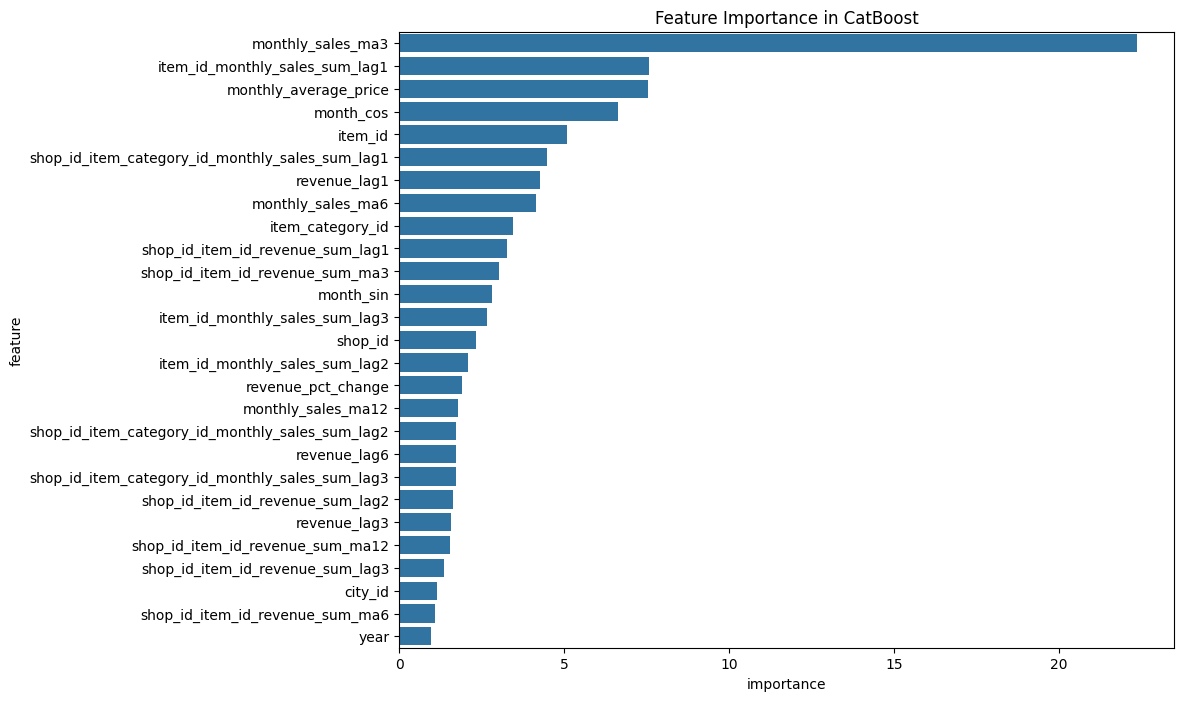

In [4894]:
from catboost import Pool
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que tu modelo ya está entrenado
feature_importances = model.get_feature_importance(Pool(X_train, Y_train), type="PredictionValuesChange")
feature_names = X_train.columns

# Crear un DataFrame con los nombres e importancias de las características
importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Ordenar el DataFrame de mayor a menor importancia
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=importances_df)
plt.title("Feature Importance in CatBoost")
plt.show()


In [4895]:
#fig, ax = plt.subplots(figsize = (10, 15))
#xgb.plot_importance(model, importance_type = "gain", ax = ax);

<a id='prediction'></a>
### Prediction
[Volver al índice](#index)<br>

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y posteriormente enviar el submit a Kaggle.

In [4896]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict

In [4897]:
X_test.reset_index(inplace = True)

In [4898]:
X_test.head(3)

,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,month_sin,month_cos,year,revenue_pct_change,revenue_lag1,revenue_lag3,revenue_lag6,monthly_sales_ma3,monthly_sales_ma6,monthly_sales_ma12,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3,shop_id_item_id_revenue_sum_ma3,shop_id_item_id_revenue_sum_ma6,shop_id_item_id_revenue_sum_ma12,shop_id_item_category_id_monthly_sales_sum_lag1,shop_id_item_category_id_monthly_sales_sum_lag2,shop_id_item_category_id_monthly_sales_sum_lag3,monthly_sales
0,12_11365,16,12,9,11365,995.680556,-0.866025,0.5,2015,-0.139988,20909.291667,6835.000000,33086.173469,13.333333,18.5,18.416667,21.0,13.0,6.0,20909.291667,24312.785714,6835.000000,17352.359127,19765.468972,18935.788779,111.0,94.0,96.0,16.424416
1,12_11369,16,12,9,11369,1321.367605,-0.866025,0.5,2015,0.811640,39641.028139,24322.876190,22666.001306,27.000000,28.5,29.250000,30.0,21.0,30.0,39641.028139,21881.300000,24322.876190,28615.068110,27793.590646,27682.585351,111.0,94.0,96.0,26.409486
2,12_11370,16,12,9,11370,681.715341,-0.866025,0.5,2015,-0.092695,20451.460229,12313.213287,16792.048629,30.000000,30.0,30.000000,30.0,30.0,30.0,20451.460229,22540.892857,12313.213287,18435.188791,16939.804119,16302.188628,111.0,94.0,96.0,29.929400


In [4899]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [4900]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 2_573
Validation RMSE: 2_764


In [4901]:
# Concatenar output_df y predictions_df, uno debajo del otro
#combined_df_white_plateau = pd.concat([output_df, predictions_df], ignore_index=True)

In [4902]:
combined_flag=False
if combined_flag:
    # Concatenar y luego ordenar
    combined_df = pd.concat(
        [X_test[["unique_id", "monthly_sales"]], combined_df_white_plateau],
        ignore_index=True
    )
    combined_df.sort_values(by="unique_id", inplace=True)  # Ordenar en su lugar
    print(combined_df.head(10))  # Mostrar las primeras 10 filas
    (
    combined_df[["unique_id", "monthly_sales"]]
    .to_csv(f"submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
     )
else:
    (
    X_test[["unique_id", "monthly_sales"]]
    .to_csv(f"submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
    )

    

<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

En este notebook hemos explorado la importancia en Machine Learning de utilizar un modelo benchmark cuando nos enfrentamos por primera vez a un nuevo dataset.

Establecer el benchmark nos ayuda a entender cual es el punto de partida.

Al entrenar un modelo, tenemos ya un notebook funcional que nos permite entrar en la siguiente loop:

1. Hacer un poco más de EDA.
1. Construir nuevas variables.
1. Probar estas variables en el modelo.
1. Guardar el score para ver la mejora o no (Kaggle Submit).
1. Volver al punto 1.

A continuación dejamos algunas ideas que los alumnos pueden implementar para mejorar el benchmark:

1. Probad otras combinaciones de variables.
1. Darle más profundidad a los lags/shifts.
1. Implementar medias móviles (ojo variables autoexplicativas).
1. Utilizar otras columnas en vez de MONTHLY_SALES para construir las variables.
1. Probar otros algoritmos.
1. Tunnear los hiperparametros del modelo.

### Happy Kaggling :)

<a id='referencias'></a>
### Referencias y lecturas recomendables
[Volver al índice](#index)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[The importance of Benchmarking](https://blog.bigml.com/2020/03/20/machine-learning-benchmarking-youre-doing-it-wrong/)

[Tree Based Models and Extrapolation (MUY RECOMENDABLE)](https://shanminlin.medium.com/how-to-help-tree-based-models-extrapolate-7954287b1219)

[XGBoost](https://xgboost.readthedocs.io/en/stable/)